# Load Library

In [ ]:
! pip install dataframe-image &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import statistics
import math
from collections import Counter

import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.sandbox.stats.multicomp import MultiComparison
from scipy.stats import chi2_contingency
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import dataframe_image as dfi

%matplotlib inline

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [ ]:
# From Local
#file_path_patient = "covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
#file_path_patient_extra = "meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
#file_path_zip_tx = 'zip_code_data.csv'
#file_path_census_tract = 'zcta_tract_rel_10.txt'
#file_path_svi_tx = 'Texas.csv'

# From Google Drive
file_path_patient = "/content/drive/MyDrive/Colab Notebooks/allocation-vent/Seton COVID Cohort Dataset Share SDH/covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
file_path_patient_extra = "/content/drive/MyDrive/Colab Notebooks/allocation-vent/Seton COVID Cohort Dataset Share SDH/meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
file_path_zip_tx = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/zip_code_data.csv'
file_path_census_tract = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/zcta_tract_rel_10.txt'
file_path_svi_tx = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/Texas.csv'

# Read csv as a dataframe from the path
df = pd.read_csv(file_path_patient, index_col=False)
df_extra = pd.read_csv(file_path_patient_extra, index_col=False)
df_zip_tx = pd.read_csv(file_path_zip_tx, index_col=False)
df_census_tract = pd.read_csv(file_path_census_tract, index_col=False)
df_svi_tx = pd.read_csv(file_path_svi_tx)

# Define Functions

In [ ]:
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence
# https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2663-7
# https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Week-and-County-Soc/9hdi-ekmb

calibration_mortality_sofa = {
    0: 0.0,
    1: 0.0,
    2: 6.4,
    3: 6.4,
    4: 20.2,
    5: 20.2,
    6: 21.5,
    7: 21.5,
    8: 33.3,
    9: 33.3,
    10: 50.0,
    11: 50.0,
    12: 95.2,
    13: 95.2,
    14: 95.2,
    15: 95.2,
    16: 95.2,
    17: 95.2,
    18: 95.2,
    19: 95.2,
    20: 95.2,
    21: 95.2,
    22: 95.2,
    23: 95.2,
    24: 95.2
}

def calculate_sofa(patient):    # Calculate SOFA scores
    score = 0
    
    # 1. Respiratory system: PaO2/FiO2 (mmHg)
    if (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 300 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 399:
        score += 1 
        
    elif ((patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 200 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 299) or ((patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] == np.nan):
        score += 2
        
    #elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'].notnull() == True:
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] != np.nan:
        score += 3
        
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 < 100 and patient['vent_hours_summed'] != np.nan:
        score += 4
        
    # 2. Nervous system: Glasgow Coma Scale
    if patient['Glasgow_Coma_Score'] == 13 or patient['Glasgow_Coma_Score'] == 14:
        score += 1 
        
    elif patient['Glasgow_Coma_Score'] >= 10 and patient['Glasgow_Coma_Score'] <= 12:
        score += 2
        
    elif patient['Glasgow_Coma_Score'] >= 6 and patient['Glasgow_Coma_Score'] <= 9:
        score += 3
        
    elif patient['Glasgow_Coma_Score'] < 6:
        score += 4
    
    # 3. Cardiovascular system: Mean arterial pressure (MAP) OR administration of vasopressors required
    if patient['Mean_Arterial_Pressure'] < 70:
        score += 1 
    
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] <= 5) or (patient['medication_name']=='dobuTamine' and patient['dose_of_medication'] !=np.nan):
        score += 2

    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 5 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] <= 0.1) or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] <= 0.1):
        score += 3
   
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 15 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] > 0.1) or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] > 0.1):
        score += 4

    # 4. Liver: Bilirubin (mg/dl) [μmol/L] 
    if float(patient['Bili_Total']) >= 1.2 and float(patient['Bili_Total']) <= 1.9:
        score += 1 
        
    elif float(patient['Bili_Total']) >= 2.0 and float(patient['Bili_Total']) <= 5.9:
        score += 2
        
    elif float(patient['Bili_Total']) >= 6.0 and float(patient['Bili_Total']) <= 11.9:
        score += 3
        
    elif float(patient['Bili_Total']) >= 12.0:
        score += 4

    # 5. Coagulation: Platelets ×103/ml
    if patient['Platelet'] >= 100 and patient['Platelet'] < 150:
        score += 1 
        
    elif patient['Platelet'] >= 50 and patient['Platelet'] < 100:
        score += 2
        
    elif patient['Platelet'] >= 20 and patient['Platelet'] < 50:
        score += 3
        
    elif patient['Platelet'] < 20:
        score += 4
        
    # 6. Kidneys: Creatinine (mg/dl) [μmol/L]; urine output
    if patient['Creatinine'] >= 1.2 and patient['Creatinine'] <= 1.9:
        score += 1 
        
    elif patient['Creatinine'] >= 2.0 and patient['Creatinine'] <= 3.4:
        score += 2
        
    elif patient['Creatinine'] >= 3.5 and patient['Creatinine'] <= 4.9:
        score += 3
        
    elif patient['Creatinine'] >= 5.0:
        score += 4 
    
    return score

def count_comorbidity(patient): # Calculate comorbidity conditions
    count = 0 
    
    if patient.COPD_com_flag == 1:
        count += 1 
        
    if patient.asthma_com_flag == 1:
        count += 1 
        
    if patient.diabetes_com_flag == 1:
        count += 1 
        
    if patient.hypertension_com_flag == 1:
        count += 1 
        
    if patient.CAD_com_flag == 1:
        count += 1 
        
    if patient.heartfailure_com_flag == 1: 
        count += 1 
        
    if patient.CKD_com_flag == 1:
        count += 1 
        
    if patient.cancer_com_flag == 1:
        count += 1 
        
    return count

def percentage_death(svi): # Calculate percentage of deaths for each race
    count = count_svi[svi.SVI] # Number of patients in their racial groups
    
    return (svi.count_death / count) * 100

ls_race = ['White', 'Black or African American', 'Hispanic or Latino', 'Asian']
def latinx(patient):    # Clean up race/ethnicity
    if patient['ethnicity_display'] == 'Hispanic or Latino' and patient['race_display'] == 'White':
        return "Hispanic or Latino"
    elif patient['ethnicity_display'] == 'Not Hispanic or Latino' and patient['race_display'] == 'White': 
        return "White"
    elif patient['race_display'] == 'Hispanic':
        return "Hispanic or Latino"
    else:
        return patient['race_display']

ls_svi = ['Low', 'Moderate', 'High']
def categorize_svi(patient):    # Clean up race/ethnicity
    if patient['RPL_THEMES'] < 0:
        return "Unknown"
    elif patient['RPL_THEMES'] >= 0 and patient['RPL_THEMES'] <= 0.333: 
        return "Low"
    elif patient['RPL_THEMES'] >= 0.334 and patient['RPL_THEMES'] <= 0.666: 
        return "Moderate"
    elif patient['RPL_THEMES'] >= 0.667 and patient['RPL_THEMES'] <= 1: 
        return "High"

def visualize_count_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='count_death', hue='SVI', data=df, kind='bar', height=4, aspect=3, order=x_val)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Count')
    plt.show()
    #sns_plot.savefig("figure/svi/count_death_{}_svi.png".format(policy))
    sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/count_death_{}_svi.png".format(policy))

def visualize_percentage_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='percentage_death', hue='SVI', data=df, kind='bar', order=x_val, height=4, aspect=3)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Rate')
    sns_plot._legend.set_title('SVI')
    #sns_plot.savefig("figure/svi/percentage_death_{}_svi.png".format(policy))
    sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/percentage_death_{}_svi.png".format(policy))   

# Preprocess Data

## Data: Extra

In [ ]:
# Extract only rows containing 'mcg/kg/min'.
# Remove 'mcg/kg/min' from string and convert the numeric values into float.
df_extra = df_extra.loc[df_extra['dose_of_medication'].str.contains('mcg/kg/min')].copy()
df_extra['dose_of_medication'] =  df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('mcg/kg/min', '0', x)).copy()
df_extra['dose_of_medication'] = df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('\ .*','', x)).copy()
df_extra['dose_of_medication'] = df_extra['dose_of_medication'].astype(float)

# There are encounters that have multiple 'dose_of_medication' for each encounter
# Extract only rows including the maximum values in 'dose_of_medication' for each encounter.
df_extra = df_extra.groupby(['medication_name', 'deid_fin_encounter']).max().reset_index()

print(df_extra.shape)
df_extra.head()

(147, 5)


,medication_name,deid_fin_encounter,dose_of_medication,administration_dt_tm,SOFA
0,dobuTamine,25093,2.50,2020-10-26T13:00:00.000-05:00,NaN
1,dobuTamine,30090,5.00,2020-09-10T12:40:00.000-05:00,NaN
2,dobuTamine,36262,5.00,2020-10-21T15:00:00.000-05:00,NaN
3,dobuTamine,44845,0.75,2020-11-13T00:19:00.000-06:00,NaN
4,dopamine,32723,0.00,2020-11-05T11:56:00.000-06:00,NaN


## Data: Zip Code

In [ ]:
# Delete columns: male_poverty_rate, female_poverty_rate, mean_income
df_zip_tx =  df_zip_tx.loc[:, ['zip_code', 'median_income', 'poverty_rate']]

print(df_zip_tx.shape)
df_zip_tx.head()

(1935, 3)


,zip_code,median_income,poverty_rate
0,ZCTA5 75001,72512,10.9
1,ZCTA5 75002,101429,4.9
2,ZCTA5 75006,64462,10.8
3,ZCTA5 75007,86648,6.7
4,ZCTA5 75009,111146,4


In [ ]:
df_zip_tx['zip_code'] = df_zip_tx['zip_code'].apply(lambda row: row.strip('ZCTA5 '))

ls_zip_error = []   
for code in df_zip_tx['zip_code']: # There zip codes that are not 5-digit number
    if len(code) != 5:
        ls_zip_error.append(code)

print("All zip codes: {}".format(len(df_zip_tx)))
print("Normal zip codes (5-digit): {}".format(len(df_zip_tx)-len(ls_zip_error)))
print('Abnormal zip codes (Non 5-digit): {}'.format(len(ls_zip_error)))

All zip codes: 1935
Normal zip codes (5-digit): 1744
Abnormal zip codes (Non 5-digit): 191


In [ ]:
# https://www.zipcodestogo.com/Texas/
# https://worldpopulationreview.com/zips/texas

#for code in ls_zip_error:
#    print("------------------------------------------------")
#    print(df_zip.loc[df_zip["zip_code"]==code, "zip_code"])
#    print(df_zip.loc[df_zip["zip_code"].str.contains(code), "zip_code"])

# Erroneous zip codes are cut off if there are single or continuous 5
for zip_error in ls_zip_error:  # Attach 5s as last digits to erroneous zip codes
  if len(zip_error) == 4:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5)
  elif len(zip_error) == 3:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(55)
  elif len(zip_error) == 1:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5555)

df_zip_tx["zip_code"] = df_zip_tx["zip_code"].astype(int)

## Data: Census Tract

In [ ]:
# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-census-tract-record-layout.html

# Extract only data from Texas state(=48)
df_census_tract_tx = df_census_tract.loc[df_census_tract['STATE']==48].copy()
df_census_tract_tx.reset_index(drop=True, inplace=True)

print(df_census_tract_tx.shape)
df_census_tract_tx.head()

# Extract only data from Texas state Travis county
# df_census_tract_tx_travis = df_census_tract.loc[(df_census_tract['STATE']==48) & (df_census_tract['COUNTY']==453)].copy()

(10009, 25)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,73949,48,421,950200,48421950200,410,190,287805986,287805986,1688,764,1366353259,1360361346,3034,1252,2391079318,2390650564,24.29,24.87,21.06,21.16,13.51,15.18,12.04,12.04
1,75001,48,113,13616,48113013616,4152,3223,2014512,2014512,12414,8102,9940470,9931768,5611,4018,3630263,3630263,33.45,39.78,20.27,20.28,74.00,80.21,55.49,55.49
2,75001,48,113,13725,48113013725,0,0,247511,247511,12414,8102,9940470,9931768,3615,1909,1839456,1839456,0.00,0.00,2.49,2.49,0.00,0.00,13.46,13.46
3,75001,48,113,13726,48113013726,2673,1488,1593774,1585072,12414,8102,9940470,9931768,2673,1488,1593774,1585072,21.53,18.37,16.03,15.96,100.00,100.00,100.00,100.00
4,75001,48,113,13727,48113013727,3231,1983,4937525,4937525,12414,8102,9940470,9931768,3235,1984,5171932,5171932,26.03,24.48,49.67,49.71,99.88,99.95,95.47,95.47


In [ ]:
# print(set(df_zip_tx["zip_code"]).difference(set(df_census_tract_tx["ZCTA5"])))
# print(set(df_census_tract_tx["ZCTA5"]).difference(set(df_zip_tx["zip_code"])))
# ls_zip_unmatched = set(df_zip_tx["zip_code"]).difference(df_census_tract_tx["ZCTA5"])

# Remove zip codes not associated with Texas
ls_idx = df_census_tract_tx.index
ls_idx_drop = []

for code in [73949, 88063, 88220, 88430]:
  idx = ls_idx[df_census_tract_tx["ZCTA5"]==code]
  ls_idx_drop.append(idx.to_list()[0])

df_census_tract_tx.drop(ls_idx_drop, inplace=True)

## Data: SVI

It seems that different zip codes indicate one single GEOID(Census Tract). In other words, the census tract number can indicate multiple zip codes.

In [ ]:
# https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

# Use only columns for socioeconomic status: 'FIPS', 'E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP'
df_svi_tx = df_svi_tx[[
    'FIPS', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL']]

print(df_svi_tx.shape)
df_svi_tx.head()

(5254, 19)


,FIPS,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,48001950100,5164,827,16.2,65,3.1,26849,386,10.9,0.3853,0.7610,0.1308,0.7545,0.4965,0,0,0,1,1
1,48001950401,4872,3,1.0,0,0.0,2520,1061,25.4,0.4162,0.0230,0.3439,0.5421,0.2477,1,0,0,1,2
2,48001950402,7548,44,20.3,4,2.2,1329,2190,30.3,0.6895,0.0626,0.3219,0.3123,0.3422,1,1,0,1,3
3,48001950500,4569,946,21.1,110,5.3,15961,577,19.5,0.7202,0.7878,0.6467,0.9167,0.8433,0,0,0,0,0
4,48001950600,5570,549,10.0,99,3.8,19854,1053,28.6,0.5552,0.4861,0.2766,0.7387,0.5470,0,0,0,0,0


In [ ]:
# Replace SVI scores that are -999(NULL) with numpy nan value
df_svi_tx.loc[df_svi_tx["RPL_THEMES"] < 0, "RPL_THEMES"] = np.nan

## Data: Sample(df_icu)

In [ ]:
# Patients who were admitted to ICU, had SOFA scores, and were in one of racial groups (White, Black or African American, Hispanic or Latino, Asian)
df_icu = df.loc[df['icu_hours_summed'].notnull()]

print(df_icu.shape)
df_icu.head()

(741, 70)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,4dMaH,61003,10650
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,False,False,False,False,False,False,False,False,3.0,8wQnr,84969,27818
6,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,False,False,False,False,False,False,False,False,1.0,P9yRo,80030,23744
11,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,False,False,False,False,False,False,False,False,2.0,23f5M,84794,37705
17,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,False,True,False,True,False,False,False,False,0.0,mNyVy,84725,15345


In [ ]:
# Make a distinction between White and Hispanic/Latino
df_icu.loc[:, ['race_display']] = df_icu.loc[:, ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1)
df_icu = df_icu.loc[df_icu['race_display'].isin(ls_race)]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
# Fill out the missing values in columns related to comorbodity conditions with 0
# Convert True/False value into 1/0
cols_comorbidity = ['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
                    'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
                    'CKD_com_flag', 'cancer_com_flag']

df_icu[cols_comorbidity] = df_icu[cols_comorbidity].fillna(0)
df_icu[cols_comorbidity] = df_icu[cols_comorbidity].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Generate columns for comorbidity count and flag
df_icu['count_comorbidity'] = df_icu.apply(lambda patient: count_comorbidity(patient), axis=1)
df_icu['has_comorbidity'] = df_icu['count_comorbidity'].apply(lambda count: 1 if count >= 1 else 0)

In [ ]:
# Generate column for age
df_icu['life_years'] = df_icu['age_at_admit'].apply(lambda age: 100 - age)

In [ ]:
# Filter out patients who do not have specific zip codes or have ones out ot Texas
display(df_icu.loc[(df_icu['zip_cust_table']=='Unknown') | (df_icu['zip_cust_table']=='10029')])
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='Unknown'], inplace=True)
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='10029'], inplace=True)
df_icu['zip_cust_table'] = df_icu['zip_cust_table'].astype(int)

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,0,NaN,4dMaH,61003,10650,0,0,51
867,2020-11-21 15:03:00,NaN,Medical Center,IP ICU,68,Female,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,33.13,2020-11-21 20:16:00,2020-11-23 05:24:00,NaN,Not yet chart searched,NaN,2.8,2.30,26,37.0,0.9,NaN,44.0,80.500,NaN,15.0,26.7,Room air,92.0,207.0,NaN,NaN,21.0,77.0,0.01,8.6,NaN,NaN,nv,62.0,55.0,Positive,Nasal Swab,81.0,36.2,32.50,False,0,0,0,0,0,0,0,0,1.0,KJhah,85695,47051,0,0,32
1790,2020-08-27 22:44:00,2020-08-30 12:58:00,Dell Seton Med Cntr UT,IP Private Room,77,Male,10029,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,2.58,I16.1,NaN,Skilled Nursing Care,Rehab/SNF,Insured,Transfer from a Hospital,NaN,NaN,NaN,NaN,23.33,2020-08-27 20:50:00,2020-08-28 20:10:00,NaN,Not yet chart searched,NaN,3.5,1.74,14,26.0,0.4,NaN,101.0,67.700,NaN,15.0,44.7,Room air,100.0,206.0,NaN,NaN,19.0,204.0,0.07,3.9,NaN,NaN,NaN,73.0,NaN,NaN,NaN,68.0,37.2,67.70,False,0,0,1,0,0,1,1,0,0.0,lhGr0,66795,25189,3,1,23
2221,2020-11-20 17:10:00,NaN,Dell Seton Med Cntr UT,IP Private Room,81,Male,Unknown,Not Hispanic or Latino,White,White Non Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,53.13,2020-11-20 22:39:00,2020-11-23 03:47:00,NaN,Not yet chart searched,NaN,1.2,1.53,40,102.0,0.5,1325,90.0,89.811,70.0,15.0,26.0,Room air,95.0,158.0,NaN,NaN,26.0,188.0,3.28,5.9,15.0,NaN,WEAKNESS,76.0,122.7,NaN,NaN,90.0,37.7,23.05,False,0,0,0,0,0,0,0,1,1.0,38pPG,70970,31680,1,1,19
2224,2020-11-21 14:10:00,NaN,Dell Seton Med Cntr UT,IP ICU,64,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,NaN,Still a patient,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,1.73,2020-11-21 12:26:00,2020-11-21 14:10:00,NaN,Not yet chart searched,NaN,0.9,0.69,50,67.0,0.4,3449,58.0,55.200,70.0,15.0,5.8,"Nasal cannula, high flow",96.0,253.0,NaN,0.33,30.0,127.0,0.05,4.6,30.0,NaN,NaN,NaN,NaN,NaN,NaN,79.0,36.9,NaN,True,0,0,0,0,0,0,0,0,1.0,PjvWN,66350,46545,0,0,36


## Merge dataframes

### df_icu & df_extra

In [ ]:
df_icu = df_icu.merge(df_extra, on='deid_fin_encounter', how='left')

print(df_icu.shape)
df_icu.head()

(712, 77)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,NaN
1,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,0,0,0,0,0,0,0,0,1.0,P9yRo,80030,23744,0,0,51,NaN,NaN,NaN,NaN
2,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,0,0,0,0,0,0,0,0,2.0,23f5M,84794,37705,0,0,76,NaN,NaN,NaN,NaN
3,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,0,1,0,1,0,0,0,0,0.0,mNyVy,84725,15345,2,1,45,NaN,NaN,NaN,NaN
4,2020-03-31 21:23:00,2020-04-08 14:40:00,Medical Center,IP Private/Semi Private room,40,Female,78704,Unknown,White,White Unknown Ethnicity,7.71,A41.89,NaN,Home,Home,Insured,Emergency Dept,Ambulance,NaN,NaN,NaN,47.40,2020-04-02 17:18:00,2020-04-04 16:42:00,Hospital Housekeeping,HCW,Employed,0.7,NaN,44,45.0,0.3,264,82.0,136.078,45.0,15.0,NaN,Room air,94.0,229.0,77.5,NaN,23.0,133.0,<0.01,2.8,2.0,NaN,FEVER,62.0,99.0,NaN,NaN,104.0,37.6,54.350000,False,0,0,0,0,0,0,0,1,1.0,wTtMC,74571,18447,1,1,60,NaN,NaN,NaN,NaN


In [ ]:
# Add SOFA scores based on extra dataset
df_icu.loc[:, ['SOFA']] = df_icu.apply(lambda row: calculate_sofa(row), axis=1)

In [ ]:
df_icu['SOFA']

0      11
1       2
2       9
3       4
4       3
       ..
707     5
708     0
709     0
710     0
711     3
Name: SOFA, Length: 712, dtype: int64

### df_census_tract_tx & df_svi_tx

In [ ]:
ls_geoid = df_census_tract_tx["GEOID"].unique()
ls_fips = df_svi_tx["FIPS"].unique()

print("Unidentified FIPS codes in active in df_census_tract_tx")
print("Exist in df_svi_tx but not in df_census_tract_tx")
print((set(ls_fips).difference(set(ls_geoid))))

Unidentified FIPS codes in active in df_census_tract_tx
Exist in df_svi_tx but not in df_census_tract_tx
{48039990000, 48071710600}


In [ ]:
df_svi_tract = df_census_tract_tx.merge(df_svi_tx, left_on='GEOID', right_on='FIPS', how='inner')
df_svi_tract.drop(columns=['FIPS'], inplace=True)
df_svi_tract = df_svi_tract.sort_values(by=['ZCTA5']).reset_index(drop=True)
print(df_svi_tract.shape)
df_svi_tract.head()

(10005, 43)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,75001,48,113,13616,48113013616,4152,3223,2014512,2014512,12414,8102,9940470,9931768,5611,4018,3630263,3630263,33.45,39.78,20.27,20.28,74.00,80.21,55.49,55.49,7223,528,7.3,121,2.2,49609,409,7.3,0.1157,0.0103,0.6218,0.2275,0.0891,0,0,0,1,1
1,75001,48,113,20700,48113020700,0,0,132554,132554,12414,8102,9940470,9931768,5022,2323,6197519,6008118,0.00,0.00,1.33,1.33,0.00,0.00,2.14,2.21,4523,381,8.4,88,3.0,46286,333,8.9,0.1754,0.1486,0.3942,0.0648,0.1012,0,0,0,0,0
2,75001,48,113,13725,48113013725,0,0,247511,247511,12414,8102,9940470,9931768,3615,1909,1839456,1839456,0.00,0.00,2.49,2.49,0.00,0.00,13.46,13.46,4009,956,23.8,89,3.9,26067,387,14.5,0.5296,0.2624,0.6318,0.6154,0.5323,0,0,0,0,0
3,75001,48,113,13806,48113013806,1,1,388475,388475,12414,8102,9940470,9931768,2515,1701,5895780,5889290,0.01,0.01,3.91,3.91,0.04,0.06,6.59,6.60,3997,206,5.2,88,2.8,52464,36,1.1,0.0489,0.0142,0.4311,0.5544,0.1154,0,0,0,1,1
4,75001,48,113,13726,48113013726,2673,1488,1593774,1585072,12414,8102,9940470,9931768,2673,1488,1593774,1585072,21.53,18.37,16.03,15.96,100.00,100.00,100.00,100.00,2896,470,16.4,95,5.0,45758,156,7.3,0.3316,0.1029,0.6408,0.2250,0.2625,0,0,0,0,0


In [ ]:
# Filter zip codes that have multiple tracts
df_svi_tract_grouped_zip = df_svi_tract.groupby(['ZCTA5']).agg({'TRACT':'count'})
display(df_svi_tract_grouped_zip)

# List of zip codes that are associated with multiple tract numbers
ls_zip_multiple_tract = df_svi_tract_grouped_zip.loc[df_svi_tract_grouped_zip['TRACT']>1].index.values.tolist()

,TRACT
ZCTA5,
75001,7
75002,13
75006,14
75007,19
75009,3
...,...
79934,4
79935,4
79936,23


### df_icu & df_svi_census_tract

In [ ]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_zip_tx = df_zip_tx['zip_code'].unique()

print('Unique zip code in df_icu: {}'.format(df_icu['zip_cust_table'].nunique()))
print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
# Zip codes that found among ICU patients
# There are 2 patients who have 78761 and and 2 others 78667
print('Zip codes that exist in both df_icu and df_zip_tx: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_zip_tx)))))
print("Unidentified zip codes in active in df_icu")
print("Zip codes that exist in zip_icu but not in zip_tx")
print((set(ls_zip_icu).difference(set(ls_zip_zip_tx))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_zip_tx: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(list(set(ls_zip_icu).intersection(set(ls_zip_zip_tx))))])))

Unique zip code in df_icu: 117
Unique zip code in df_zip_tx: 1935
Zip codes that exist in both df_icu and df_zip_tx: 110
Unidentified zip codes in active in df_icu
Zip codes that exist in zip_icu but not in zip_tx
{78720, 78761, 78762, 78667, 77875, 78646, 78680}
ICU patients: 712
ICU patients who can be connected to df_zip_tx: 703


In [ ]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

# Zip codes that found among ICU patients 
print('Zip codes that exist in both df_icu and df_svi_tract: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_svi_tract)))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_svi_tract: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(ls_zip_svi_tract)])))

Zip codes that exist in both df_icu and df_svi_tract: 110
ICU patients: 712
ICU patients who can be connected to df_svi_tract: 703


In [ ]:
ls_zip = df_zip_tx['zip_code'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
print('Unique zip code in df_svi_tract: {}'.format(df_svi_tract['ZCTA5'].nunique()))
print('Zip codes that exist in both df_zip and df_svi_tract: {}'.format(len(set(ls_zip).intersection(set(ls_zip_svi_tract)))))

Unique zip code in df_zip_tx: 1935
Unique zip code in df_svi_tract: 1935
Zip codes that exist in both df_zip and df_svi_tract: 1935


In [ ]:
df_icu = df_icu.merge(df_svi_tract, left_on='zip_cust_table', right_on='ZCTA5', how='inner').copy()

print(df_icu.shape)
df_icu.head()

(6823, 120)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,187,210604,48187210604,209,78,9162841,9162841,59546,24291,242339749,239149447,7557,2884,69375073,69367930,0.35,0.32,3.78,3.83,2.77,2.70,13.21,13.21,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,91,310401,48091310401,5271,1740,4265526,4260791,59546,24291,242339749,239149447,5626,1881,6712616,6685051,8.85,7.16,1.76,1.78,93.69,92.50,63.54,63.74,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,187,210508,48187210508,113,55,24007353,23907887,59546,24291,242339749,239149447,2662,941,91744377,91319548,0.19,0.23,9.91,10.00,4.24,5.84,26.17,26.18,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hisp

In [ ]:
# Filter encounter ids that have multiple tracts 
df_icu_group_id = df_icu.groupby(['deid_fin_encounter']).agg({'TRACT':'count'}).sort_values(by="TRACT", ascending=False).reset_index()
df_icu_group_id

,deid_fin_encounter,TRACT
0,44845,57
1,32723,48
2,33974,39
3,30090,36
4,33932,36
...,...,...
670,41226,2
671,44013,1
672,13106,1
673,46271,1


In [ ]:
# Filter zip codes that have multiple tracts 
df_icu_group_zip = df_icu.groupby(['ZCTA5']).agg({'TRACT':'count'}).sort_values(by='TRACT', ascending=False).reset_index()
df_icu_group_zip

,ZCTA5,TRACT
0,78753,720
1,78744,429
2,78640,400
3,78741,390
4,78666,306
...,...,...
105,79845,2
106,77988,1
107,78948,1
108,78159,1


## Drop necessary columns and Generate df_sample

In [ ]:
cols_sample = [
    'deid_fin_encounter', 'age_at_admit', 'gender', 'race_display', 'insured_uninsured', 'icu_hours_summed', 'vent_hours_summed',
    'SOFA', 'has_comorbidity', 'count_comorbidity', 'life_years', 'discharge_disposition_display', 'deceased_dt_tm',
    'ZCTA5', 'TRACT', 'GEOID', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL'
    ]

df_sample = df_icu[cols_sample].copy()

print(df_sample.shape)
df_sample.head()

(6823, 34)


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210604,48187210604,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310401,48091310401,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210508,48187210508,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210507,48187210507,7022,572,8.1,114,3.2,37467,350,8.2,0.2003,0.3312,0.2833,0.1289,0.1615,0,0,0,0,0
4,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310300,48091310300,7669,782,10.7,16,0.5,39723,367,6.4,0.1376,0.7062,0.1572,0.8164,0.3996,0,1,0,1,2


## Remove duplicate TRACT

In [ ]:
# List of patients who are recorded with multiple tract numbers in a single zip code
ls_patient_multi_tract = df_sample.loc[df_sample['deid_fin_encounter'].duplicated()==True, 'deid_fin_encounter'].unique().tolist()

# Count patients for each tract number
df_tract_cnt_patient = df_sample.loc[df_sample['ZCTA5'].isin(ls_zip_multiple_tract)].groupby(['TRACT']).agg({'deid_fin_encounter':'count'}).reset_index()
df_tract_cnt_patient.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)

print(df_tract_cnt_patient.shape)
df_tract_cnt_patient.head()

(506, 2)


,TRACT,count_patient
0,100,35
1,101,12
2,102,11
3,106,1
4,107,1


In [ ]:
# Calculate variance of SVI scores among patients having multiple TRACT numbers
# Leave only tract number for each patient that has the most number of patients
ls_var = []

for idx, id in enumerate(ls_patient_multi_tract):
    
    ls_tract_per_patient = df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT'].tolist() # make a list of multiple tract numbers for a single patient
    df_tmp_per_patient = df_tract_cnt_patient.loc[df_tract_cnt_patient['TRACT'].isin(ls_tract_per_patient)] # Number of patients for each tract number
    
    var = statistics.variance(df_sample.loc[df_sample['deid_fin_encounter']==id, 'RPL_THEMES'].values)  # Calculate variance of SVI scores of multiple tract numbers for each patient
    ls_var.append(var)

    max_tract = df_tmp_per_patient[df_tmp_per_patient['count_patient']==df_tmp_per_patient['count_patient'].max()]['TRACT'].values[0]   # Pick a tract number that has the maximum number of patients
    ls_drop_tract = df_sample.loc[df_sample['deid_fin_encounter']==id].index[df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT']!=max_tract].tolist()   # List of tract numbers except the one with maximum number of patients
    df_sample.drop(ls_drop_tract, inplace=True)

In [ ]:
# Categorize SVI values into three sets
df_sample.loc[:, ['cat_SVI']] = df_sample.loc[:, ['RPL_THEMES']].apply(lambda patient: categorize_svi(patient), axis=1)
df_sample = df_sample.loc[df_sample['cat_SVI'].isin(ls_svi)]

Variance of SVI scores of sample: 0.0832388887032814
Variance of SVI scores of Texas: 0.08336533097388593
Average variance of SVI scores: 0.04336678860168124
Max SVI score: 0.9969
Min SVI score: 0.0063


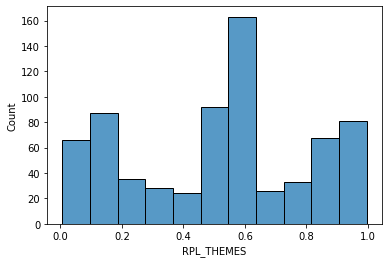

In [ ]:
print("Variance of SVI scores of sample: {}".format(np.nanvar(df_sample['RPL_THEMES'].values)))
print("Variance of SVI scores of Texas: {}".format(np.nanvar(df_svi_tx['RPL_THEMES'].values)))
print("Average variance of SVI scores: {}".format(np.nanmean(ls_var)))
print("Max SVI score: {}".format(df_sample['RPL_THEMES'].max()))
print("Min SVI score: {}".format(df_sample['RPL_THEMES'].min()))

sns.histplot(data=df_sample['RPL_THEMES'])

## Distribution of SOFA scores

In [ ]:
df_sample_pct_sofa = df_sample.groupby(['SOFA']).agg({'deid_fin_encounter': 'count'}).copy()
df_sample_pct_sofa['percentage'] = df_sample_pct_sofa.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
df_sample_pct_sofa.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
df_sample_pct_sofa

,count_patient,percentage
SOFA,,
0,147,0.21
1,86,0.12
2,47,0.07
3,67,0.10
4,92,0.13
5,62,0.09
6,49,0.07
7,32,0.05
8,33,0.05


In [ ]:
count_svi = Counter(df_sample['cat_SVI'])
count_svi

Counter({'High': 191, 'Low': 206, 'Moderate': 306})

In [ ]:
df_left = df_sample.groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_patients'})
df_tmp = {"SOFA": 16, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_left = df_left.sort_values(by=["SOFA"]).reset_index(drop=True)

df_right = df_sample.loc[df_sample['discharge_disposition_display']=='Expired'].groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_death'})
df_tmp = {"SOFA": 14, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 16, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_right = df_right.sort_values(by=["SOFA"]).reset_index(drop=True)

In [ ]:
df_center = df_left.merge(df_right, on='SOFA', how='left')
df_center['percentage_death'] = round(df_center['num_death']/df_center['num_patients']*100, 0)
df_center

,SOFA,num_patients,num_death,percentage_death
0,0,147,3,2.0
1,1,86,4,5.0
2,2,47,4,9.0
3,3,67,16,24.0
4,4,92,22,24.0
5,5,62,20,32.0
6,6,49,21,43.0
7,7,32,9,28.0
8,8,33,15,45.0
9,9,36,20,56.0


In [ ]:
tmp = df_sample.groupby(by=["race_display"]).agg({'deid_fin_encounter': 'count'})
tmp['percentage'] = tmp.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
tmp.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
tmp = tmp.reset_index()
tmp

,race_display,count_patient,percentage
0,Asian,7,0.01
1,Black or African American,61,0.09
2,Hispanic or Latino,376,0.53
3,White,259,0.37


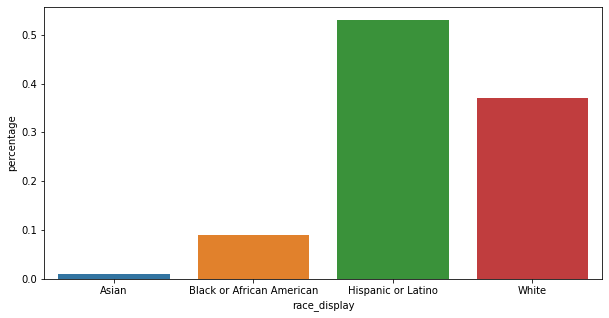

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=tmp,
    x="race_display",
    y="percentage"
)

# Develop allocation

In [ ]:
df_sample.columns

Index(['deid_fin_encounter', 'age_at_admit', 'gender', 'race_display',
       'insured_uninsured', 'icu_hours_summed', 'vent_hours_summed', 'SOFA',
       'has_comorbidity', 'count_comorbidity', 'life_years',
       'discharge_disposition_display', 'deceased_dt_tm', 'ZCTA5', 'TRACT',
       'GEOID', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI',
       'E_NOHSDP', 'EP_NOHSDP', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3',
       'RPL_THEME4', 'RPL_THEMES', 'F_THEME1', 'F_THEME2', 'F_THEME3',
       'F_THEME4', 'F_TOTAL', 'cat_SVI'],
      dtype='object')

In [ ]:
iter_simulation = 1000  # The number of simulations

vent_availability = np.linspace(0,1,11)   # Ventilator availability as percentage
vent_availability.round(1)

class Allocation(object):
  
    def __init__(self, df, vent_availability, calibration_mortality_sofa):
        self.patient = df.copy() 
        self.patient['death'] = [0 for _ in range(len(self.patient))]    # All patients initially survive
        self.patient['vent'] = [0 for _ in range(len(self.patient))]     # All patients are not initially allocated to a ventilator
        self.num_vent = int(len(self.patient) * vent_availability)       # Number of ventilators available
        self.mortality_sofa = calibration_mortality_sofa                 # Mortality for SOFA

    def __run_allocation(self, df): # Analytical approach
        df_prioritized = df.copy()
        df_prioritized.reset_index(drop=True, inplace=True)

        print('-----------------------------------Number of ventilators available: {}-----------------------------------'.format(self.num_vent))
        
        for i, patient in df_prioritized.iterrows():

            if df_prioritized.loc[df_prioritized['vent']==1].shape[0] == self.num_vent:                      # If no more ventialtors available, then stop allocating ventilators
                break
            
            df_prioritized.loc[i, 'vent'] = 1
        
        if (self.num_vent != 0) and (df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'].values == df_prioritized.loc[df_prioritized.index==(self.num_vent), 'SOFA'].values):    # When a tie occurs
            
            print('-----------------------------------Tie occurs-----------------------------------')
            tie_sofa = df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'].values # Find SOFA score that causes a tie
          
            print('-----------------------------------TIE SOFA: {}-----------------------------------'.format(tie_sofa[0]))
            print('-----------------------------------MORTALITY PROBABILITY: {}-----------------------------------'.format(self.mortality_sofa[tie_sofa[0]]))

            if df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].first_valid_index() == 0:    # When needed to cut a line from the beginning of the prioritized list

                df_tie_allocated = df_prioritized.loc[(df_prioritized['SOFA']==tie_sofa[0]) & (df_prioritized['vent']==1)].copy()
                df_tie_allocated_not = df_prioritized.loc[(df_prioritized['SOFA']==tie_sofa[0]) & (df_prioritized['vent']==0)].copy()
                df_tie_comb = pd.concat([df_tie_allocated, df_tie_allocated_not])
                
                print('-----------------------------------TIE-----------------------------------')
                df_count_death_tie = self.mortality_tie(df_tie_comb, tie_sofa[0]).copy()

                print('-----------------------------------NOT ALLOCATED-----------------------------------')
                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[(df_prioritized['SOFA']!=tie_sofa[0]) & (df_prioritized['vent']==0)].copy())

                print('-----------------------------------FINAL-----------------------------------')
                df_count_death_final = df_count_death_tie.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                df_count_death_final = df_count_death_final[['cat_SVI', 'count_death']]
                df_count_death_final.drop_duplicates(inplace=True)

                display(df_count_death_final)
                return df_count_death_final

            else: # When needed to cut lines in the mid of the prioritized list
                cut_off_idx_before = df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].first_valid_index()
                cut_off_idx_after = df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].last_valid_index()
                
                print('-----------------------------------ALLOCATED-----------------------------------')
                df_count_death_allocated = self.mortality_allocated(df_prioritized.loc[:cut_off_idx_before-1].copy())
                
                print('-----------------------------------TIE-----------------------------------')
                df_count_death_tie = self.mortality_tie(df_prioritized.loc[cut_off_idx_before:cut_off_idx_after], tie_sofa[0]).copy()

                print('-----------------------------------NOT ALLOCATED-----------------------------------')
                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[cut_off_idx_after+1:].copy())
       
                print('-----------------------------------FINAL-----------------------------------')
                df_count_death_final = df_count_death_allocated.set_index('cat_SVI').add(df_count_death_tie.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final = df_count_death_final.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                df_count_death_final = df_count_death_final[['cat_SVI', 'count_death']]
                df_count_death_final.drop_duplicates(inplace=True)

                display(df_count_death_final)
                return df_count_death_final

        else:   # When a tie dose not occur
            if df_prioritized.loc[df_prioritized['vent']==1].empty == False:
                df_count_death_allocated = self.mortality_allocated(df_prioritized.loc[df_prioritized['vent']==1].copy())

            if df_prioritized.loc[df_prioritized['vent']==0].empty == False:
                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[df_prioritized['vent']==0].copy())
          
            if self.num_vent == 0:                    # When the scarcity level is 0.0
                display(df_count_death_allocated_not)
                return df_count_death_allocated_not
            elif self.num_vent == len(self.patient):  # When the scarcity level is 1.0
                display(df_count_death_allocated)
                return df_count_death_allocated
            else:
                df_count_death_comb = df_count_death_allocated.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                
                display(df_count_death_comb)
                return df_count_death_comb
    
    def mortality_allocated(self, df):
        print("METHOD: MORTALITY_ALLOCATED")
        df_tmp = df.groupby(['SOFA', 'cat_SVI'])[['deid_fin_encounter']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['SOFA', 'cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        display(df_tmp)

        for i, value in df_tmp.iterrows():
            #df_tmp.loc[i, 'mortality rate'] = self.mortality_sofa[df_tmp.loc[i, 'SOFA']] * 0.01
            df_tmp.loc[i, 'expected_death'] = round(df_tmp.loc[i, 'count'] * self.mortality_sofa[df_tmp.loc[i, 'SOFA']] * 0.01, 2)

        df_tmp = df_tmp.groupby('cat_SVI')[['expected_death']].agg(['sum'])
        df_tmp.rename(columns={'sum': 'expected_death'}, inplace=True)
        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        
        display(df_tmp)
        return df_tmp
        
    def mortality_allocated_not(self, df):
        print("METHOD: MORTALITY_ALLOCATED_NOT")
        for i, patient in df.iterrows():
            df.loc[i, 'death'] = 1  # Assumption in baseline paper
        display(df)
        df_tmp = df.groupby(['SOFA', 'cat_SVI'])[['death']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['SOFA', 'cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        
        df_tmp = df_tmp.groupby('cat_SVI')[['count']].agg(['sum']).copy()
        df_tmp.rename(columns={'sum': 'expected_death'}, inplace=True)
        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)

        display(df_tmp)
        return df_tmp

    def mortality_tie(self, df, tie_sofa):
        print("METHOD: MORTALITY_TIE")
        df_tmp = df.groupby(['cat_SVI', 'vent'])[['deid_fin_encounter']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['cat_SVI', 'vent'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        display(df_tmp)

        for i, value in df_tmp.iterrows():

            df_tmp.loc[i, 'P[NV] & P[V]'] = round(value['count']/df_tmp.loc[df_tmp['cat_SVI']==value['cat_SVI'], 'count'].sum(), 2)

            if value['vent'] == 0:
                df_tmp.loc[i, 'P[D|NV] & P[D|V]'] = round(1.0, 2)
            else:
                df_tmp.loc[i, 'P[D|NV] & P[D|V]'] = round(self.mortality_sofa[tie_sofa] * 0.01, 2)

            df_tmp.loc[i, 'P[D_sub]'] = df_tmp.loc[i, 'P[NV] & P[V]'] * df_tmp.loc[i, 'P[D|NV] & P[D|V]']
        
        for cat in df_tmp['cat_SVI'].unique():
          
            sum_p = df_tmp.loc[df_tmp['cat_SVI']==cat, 'P[D_sub]'].sum()

            df_tmp.loc[df_tmp['cat_SVI']==cat, 'P[D_total]'] = sum_p
            df_tmp.loc[df_tmp['cat_SVI']==cat, 'expected_death'] = df_tmp.loc[df_tmp['cat_SVI']==cat, 'count'].sum() * sum_p

        df_tmp.reset_index(drop=True, inplace=True)

        display(df_tmp)
        return df_tmp

    def __run_allocation_simulator(self, df): # Simulation approach
        df_prioritized = df.copy()
        df_prioritized.reset_index(drop=True, inplace=True)

        for i, patient in df_prioritized.iterrows():

            if df_prioritized.loc[df_prioritized['vent']==1].shape[0] == self.num_vent:                      # If no more ventialtors available, then stop allocating ventilators
                break
            
            death, vent = self.mortality_allocated_simulator(patient)
            
            df_prioritized.loc[i, 'death'] = death
            df_prioritized.loc[i, 'vent'] = vent

        df_allocated = df_prioritized.loc[df_prioritized['vent']==1].copy()
        df_allocated_not = df_prioritized.loc[df_prioritized['vent']==0].copy()
        df_allocated_not = self.mortality_allocated_not_simulator(df_allocated_not)

        df_tmp = pd.concat([df_allocated, df_allocated_not])
        df_tmp = df_tmp.groupby(['cat_SVI'])[['death']].agg(['sum']).copy()
        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)

        return df_tmp    
    
    def mortality_allocated_simulator(self, patient):

        prob = self.mortality_sofa[patient['SOFA']]             # Mortality probability for each SOFA score
        death = np.random.binomial(size=1, n=1, p=prob*.01)[0]  # Death depending on mortality probability
        
        return death, 1 
    
    def mortality_allocated_not_simulator(self, df):

        for i, patient in df.iterrows():
            df.loc[i, 'death'] = 1
        
        return df
    
    def __categorize_age(self, patient):    # Life-cycle consideration delineated in Maryland CSC
        if patient.age_at_admit < 50:
            return 1 
        elif patient.age_at_admit < 70: 
            return 2 
        elif patient.age_at_admit < 85:
            return 3 
        else:
            return 4
    
    def maryland(self):
      
        df_patient = self.patient.copy()
        df_patient['cat_age'] = df_patient.apply(lambda patient: self.__categorize_age(patient), axis=1)  # Categorize patients' age
        df_patient.sort_values(by=['SOFA', 'count_comorbidity', 'cat_age'], ascending=[True, True, True], inplace=True) # Prioritize patients who have lower SOFA score first, then small amount of comorbidities, and finally are in youger age category first
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 

    def max_lives_saved(self):

        df_patient = self.patient.copy()
        df_patient.sort_values(by=['SOFA'], ascending=True, inplace=True)  # Prioritize patients who have lower SOFA scores first
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
    
    def max_life_years(self):

        df_patient = self.patient.copy()
        df_patient.sort_values(by=['SOFA', 'life_years'], ascending=[True,False], inplace=True)  # Prioritize patients who have lower SOFA scores and then more life years to live
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
    
    def youngest(self):

        df_patient = self.patient.copy()
        df_patient.sort_values(by=['age_at_admit'], ascending=True, inplace=True)  # Prioritize patients who are younger first
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
        
    def sickest(self):

        df_patient = self.patient.copy()
        df_patient.sort_values(by=['SOFA'], ascending=False, inplace=True) # Prioritize patients who have higher SOFA scores first
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated

    def new_york(self):

        df_patient = self.patient.copy()  # Prioritize patients by shuffling orders within patients having the same SOFA scores
        group_sofa = [df for _, df in df_patient.groupby('SOFA')]               # Group patients based on SOFA scores
        random.shuffle(group_sofa)                                             # Shuffle patients in each SOFA score group randomly
        df_prioritized = pd.concat(group_sofa).reset_index(drop=True)          # Re-combine groups seperated by SOFA scores
        df_prioritized.sort_values('SOFA', ascending=True, inplace=True)       # Sort patients by SOFA scores in ascending order
        df_allocated = self.__run_allocation_simulator(df_prioritized)
        
        return df_allocated

    def lottery(self):

        df_patient = self.patient.copy()
        df_patient = df_patient.sample(frac=1)  # Prioritize patients by shuffling them
        df_prioritized = df_patient.copy()
        df_allocated = self.__run_allocation_simulator(df_prioritized)

        return df_allocated 
        

# Allocate ventilators (Baseline)

In [ ]:
death_base = Counter(df_sample.loc[df_sample['discharge_disposition_display']=='Expired']['cat_SVI'])
pd.DataFrame.from_dict(death_base, orient='index', columns=['count_death']).reset_index().rename(columns={'index': 'SVI'})

,SVI,count_death
0,Low,49
1,Moderate,75
2,High,38


In [ ]:
avg_death_base = statistics.mean(death_base.values())  # Average of deaths for all racial groups
death_base = pd.DataFrame(death_base.items(), columns=['SVI', 'count_death'])
death_base['level'] = 2.0   # Nothing about scarcity level
death_base['avg_death'] = avg_death_base
death_base['percentage_death'] = death_base.apply(lambda row: percentage_death(row), axis=1)  # Ratio of death for each racial group from total deaths
death_base['type_allocation'] = 'Baseline'
death_base

,SVI,count_death,level,avg_death,percentage_death,type_allocation
0,Low,49,2.0,54,23.786408,Baseline
1,Moderate,75,2.0,54,24.509804,Baseline
2,High,38,2.0,54,19.895288,Baseline


# Allocate ventilators (Analytical approach)

## Maryland

In [ ]:
ls_df_count_death = []

for pct in vent_availability:
    
    print('-----------------------------------Scarcity Level: {}-----------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_mortality_sofa)   # Generate Allocation object
    df_death = allocation.maryland()                                      # Prioritize patients following Maryland CSC
    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)

    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death.append(df_death)

df_maryland = pd.concat(ls_df_count_death)
df_maryland['type_allocation'] = 'Maryland'
df_base_maryland = pd.concat([death_base, df_maryland])
df_base_maryland[['count_death', 'avg_death', 'percentage_death']] = df_base_maryland[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)
display(df_base_maryland)

-----------------------------------Scarcity Level: 0.0-----------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
0,17000,47,Female,White,Insured,43.03,NaN,0,0,0,53,Still a patient,NaN,78130,310902,48091310902,9736,194,2.0,107,2.1,33293,672,10.0,0.1326,0.1659,0.2624,0.3138,0.1611,0,0,0,0,0,Low,1,0,1
1,40145,36,Male,Hispanic or Latino,Uninsured,22.03,NaN,0,0,0,64,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
2,12746,35,Male,Hispanic or Latino,Uninsured,75.75,NaN,0,0,0,65,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
3,49618,42,Male,Hispanic or Latino,Uninsured,234.37,NaN,0,0,0,58,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
4,47627,28,Male,White,Uninsured,38.70,NaN,0,0,0,72,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


-----------------------------------Scarcity Level: 0.1-----------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,14
1,High,1,26
2,Low,0,26
3,Low,1,20
4,Moderate,0,37
5,Moderate,1,24


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,14,0.35,1.0,0.35,0.35,14.00
1,High,1,26,0.65,0.0,0.00,0.35,14.00
2,Low,0,26,0.57,1.0,0.57,0.57,26.22
3,Low,1,20,0.43,0.0,0.00,0.57,26.22
4,Moderate,0,37,0.61,1.0,0.61,0.61,37.21
5,Moderate,1,24,0.39,0.0,0.00,0.61,37.21


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
147,45992,26,Female,Hispanic or Latino,Insured,31.97,NaN,1,0,0,74,Home,NaN,78612,950802,48021950802,7625,1011,13.3,334,8.6,21691,1023,24.8,0.7098,0.5127,0.6940,0.2269,0.5570,0,1,0,1,2,Moderate,1,0,1
148,18014,33,Female,Hispanic or Latino,Insured,202.25,NaN,1,0,0,67,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
149,43840,32,Male,Hispanic or Latino,Uninsured,66.17,11.08,1,0,0,68,Home,NaN,78745,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
150,48747,49,Male,Hispanic or Latino,Insured,284.55,NaN,1,0,0,51,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
151,40894,20,Female,White,Uninsured,23.15,NaN,1,0,0,80,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,151
1,Low,160
2,Moderate,245


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,165.00
2,Low,186.22
4,Moderate,282.21


-----------------------------------Scarcity Level: 0.2-----------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,1
1,High,1,39
2,Low,0,3
3,Low,1,43
4,Moderate,0,3
5,Moderate,1,58


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,1,0.02,1.0,0.02,0.02,0.80
1,High,1,39,0.98,0.0,0.00,0.02,0.80
2,Low,0,3,0.07,1.0,0.07,0.07,3.22
3,Low,1,43,0.93,0.0,0.00,0.07,3.22
4,Moderate,0,3,0.05,1.0,0.05,0.05,3.05
5,Moderate,1,58,0.95,0.0,0.00,0.05,3.05


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
147,45992,26,Female,Hispanic or Latino,Insured,31.97,NaN,1,0,0,74,Home,NaN,78612,950802,48021950802,7625,1011,13.3,334,8.6,21691,1023,24.8,0.7098,0.5127,0.6940,0.2269,0.5570,0,1,0,1,2,Moderate,1,0,1
148,18014,33,Female,Hispanic or Latino,Insured,202.25,NaN,1,0,0,67,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
149,43840,32,Male,Hispanic or Latino,Uninsured,66.17,11.08,1,0,0,68,Home,NaN,78745,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
150,48747,49,Male,Hispanic or Latino,Insured,284.55,NaN,1,0,0,51,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
151,40894,20,Female,White,Uninsured,23.15,NaN,1,0,0,80,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,151
1,Low,160
2,Moderate,245


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,151.80
2,Low,163.22
4,Moderate,248.05


-----------------------------------Scarcity Level: 0.3-----------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 1-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61


,cat_SVI,expected_death
0,High,0.0
1,Low,0.0
2,Moderate,0.0


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,5
1,High,1,13
2,Low,0,7
3,Low,1,25
4,Moderate,0,11
5,Moderate,1,25


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,5,0.28,1.0,0.28,0.28,5.04
1,High,1,13,0.72,0.0,0.00,0.28,5.04
2,Low,0,7,0.22,1.0,0.22,0.22,7.04
3,Low,1,25,0.78,0.0,0.00,0.22,7.04
4,Moderate,0,11,0.31,1.0,0.31,0.31,11.16
5,Moderate,1,25,0.69,0.0,0.00,0.31,11.16


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
233,23744,49,Female,White,Insured,160.17,293.02,2,0,0,51,Home,NaN,78612,950802,48021950802,7625,1011,13.3,334,8.6,21691,1023,24.8,0.7098,0.5127,0.6940,0.2269,0.5570,0,1,0,1,2,Moderate,1,0,1
234,28224,34,Female,White,Insured,275.02,0.77,2,0,0,66,Home,NaN,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0,1
235,22543,36,Male,White,Insured,14.57,NaN,2,0,0,64,Home,NaN,78610,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0,1
236,14719,24,Male,White,Uninsured,29.90,NaN,2,0,0,76,Home,NaN,78701,1100,48453001100,6608,890,13.8,76,1.5,109352,377,6.2,0.1301,0.0291,0.1295,0.8134,0.1809,0,0,0,2,2,Low,1,0,1
237,29012,61,Male,Hispanic or Latino,Insured,98.55,4.63,2,0,0,39,Home,NaN,78758,1805,48453001805,4675,1511,32.4,54,1.9,21702,744,24.2,0.6053,0.2306,0.8349,0.9875,0.7905,0,0,1,2,3,High,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,133
1,Low,128
2,Moderate,209


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,138.04
2,Low,135.04
4,Moderate,220.16


-----------------------------------Scarcity Level: 0.4-----------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 3-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 6.4-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26


,cat_SVI,expected_death
0,High,0.58
1,Low,0.77
2,Moderate,1.66


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,15
1,High,1,1
2,Low,0,26
3,Moderate,0,25


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,15,0.94,1.00,0.9400,0.9436,15.0976
1,High,1,1,0.06,0.06,0.0036,0.9436,15.0976
2,Low,0,26,1.00,1.00,1.0000,1.0000,26.0000
3,Moderate,0,25,1.00,1.00,1.0000,1.0000,25.0000


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
347,15850,27,Female,Hispanic or Latino,Insured,799.76,626.02,4,0,0,73,Home Care with Home Health,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
348,27967,36,Male,Hispanic or Latino,Insured,192.52,NaN,4,0,0,64,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
349,33220,0,Female,Hispanic or Latino,Insured,17.80,NaN,4,0,0,100,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
350,40065,35,Male,Hispanic or Latino,Insured,93.68,37.18,4,0,0,65,Home,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
351,17721,42,Male,Hispanic or Latino,Insured,24.28,NaN,4,0,0,58,Home,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,108
1,Low,90
2,Moderate,158


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,123.6776
2,Low,116.7700
3,Moderate,184.6600


-----------------------------------Scarcity Level: 0.5-----------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,1.60
1,Low,2.43
2,Moderate,3.26


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,31
1,High,1,4
2,Low,0,21
3,Moderate,0,36


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,31,0.89,1.0,0.890,0.912,31.92
1,High,1,4,0.11,0.2,0.022,0.912,31.92
2,Low,0,21,1.00,1.0,1.000,1.000,21.00
3,Moderate,0,36,1.00,1.0,1.000,1.000,36.00


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
439,32640,47,Male,Hispanic or Latino,Insured,138.38,94.18,5,0,0,53,Home,NaN,78758,1805,48453001805,4675,1511,32.4,54,1.9,21702,744,24.2,0.6053,0.2306,0.8349,0.9875,0.7905,0,0,1,2,3,High,1,0,1
440,49941,29,Female,White,Insured,789.70,775.33,5,0,0,71,Another Hospital,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
441,41743,25,Male,Hispanic or Latino,Insured,172.65,39.05,5,0,0,75,Home,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
442,12184,32,Male,Hispanic or Latino,Insured,980.38,1186.03,5,0,0,68,Long Term Care Hospital,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0,1
443,14658,23,Male,Hispanic or Latino,Insured,47.32,21.08,5,0,0,77,Home,NaN,78613,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,73
1,Low,69
2,Moderate,122


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,106.52
2,Low,92.43
3,Moderate,161.26


-----------------------------------Scarcity Level: 0.6-----------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,1.60
1,Low,2.43
2,Moderate,3.26


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,5
1,High,1,30
2,Low,0,7
3,Low,1,14
4,Moderate,0,6
5,Moderate,1,30


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,5,0.14,1.0,0.140,0.312,10.920
1,High,1,30,0.86,0.2,0.172,0.312,10.920
2,Low,0,7,0.33,1.0,0.330,0.464,9.744
3,Low,1,14,0.67,0.2,0.134,0.464,9.744
4,Moderate,0,6,0.17,1.0,0.170,0.336,12.096
5,Moderate,1,30,0.83,0.2,0.166,0.336,12.096


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
439,32640,47,Male,Hispanic or Latino,Insured,138.38,94.18,5,0,0,53,Home,NaN,78758,1805,48453001805,4675,1511,32.4,54,1.9,21702,744,24.2,0.6053,0.2306,0.8349,0.9875,0.7905,0,0,1,2,3,High,1,0,1
440,49941,29,Female,White,Insured,789.70,775.33,5,0,0,71,Another Hospital,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
441,41743,25,Male,Hispanic or Latino,Insured,172.65,39.05,5,0,0,75,Home,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,1
442,12184,32,Male,Hispanic or Latino,Insured,980.38,1186.03,5,0,0,68,Long Term Care Hospital,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0,1
443,14658,23,Male,Hispanic or Latino,Insured,47.32,21.08,5,0,0,77,Home,NaN,78613,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,73
1,Low,69
2,Moderate,122


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,85.520
2,Low,81.174
4,Moderate,137.356


-----------------------------------Scarcity Level: 0.7-----------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 5-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,8.67
1,Low,6.67
2,Moderate,10.53


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,1
1,High,1,14
2,Low,0,5
3,Low,1,17
4,Moderate,0,3
5,Moderate,1,22


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,1,0.07,1.0,0.070,0.256,3.840
1,High,1,14,0.93,0.2,0.186,0.256,3.840
2,Low,0,5,0.23,1.0,0.230,0.384,8.448
3,Low,1,17,0.77,0.2,0.154,0.384,8.448
4,Moderate,0,3,0.12,1.0,0.120,0.296,7.400
5,Moderate,1,22,0.88,0.2,0.176,0.296,7.400


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
501,35282,30,Male,Hispanic or Latino,Insured,227.40,226.17,6,0,0,70,Expired,7/25/2020 18:57,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
502,35901,18,Male,Hispanic or Latino,Insured,186.75,2.85,6,0,0,82,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,1
503,35699,42,Male,Hispanic or Latino,Uninsured,70.10,NaN,6,0,0,58,Still a patient,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
504,26025,28,Male,Black or African American,Uninsured,53.73,19.15,6,0,0,72,Home,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0,1
505,43833,49,Female,Hispanic or Latino,Uninsured,176.77,314.87,6,0,0,51,Still a patient,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,58
1,Low,47
2,Moderate,97


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,70.510
2,Low,62.118
4,Moderate,114.930


-----------------------------------Scarcity Level: 0.8-----------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 7-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 21.5-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,15.36
1,Low,13.91
2,Moderate,19.66


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,4
1,High,1,4
2,Low,0,7
3,Low,1,3
4,Moderate,0,9
5,Moderate,1,5


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,4,0.50,1.00,0.5000,0.6050,4.8400
1,High,1,4,0.50,0.21,0.1050,0.6050,4.8400
2,Low,0,7,0.70,1.00,0.7000,0.7630,7.6300
3,Low,1,3,0.30,0.21,0.0630,0.7630,7.6300
4,Moderate,0,9,0.64,1.00,0.6400,0.7156,10.0184
5,Moderate,1,5,0.36,0.21,0.0756,0.7156,10.0184


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
582,19753,37,Male,White,Insured,450.15,NaN,8,0,0,63,Still a patient,NaN,78758,1805,48453001805,4675,1511,32.4,54,1.9,21702,744,24.2,0.6053,0.2306,0.8349,0.9875,0.7905,0,0,1,2,3,High,1,0,1
583,21053,64,Male,Hispanic or Latino,Uninsured,92.80,100.82,8,0,0,36,Expired,4/25/2020 1:02,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,2
584,26620,52,Male,Hispanic or Latino,Uninsured,130.25,134.18,8,0,0,48,Expired,6/30/2020 21:40,78660,1840,48453001840,11694,1706,14.6,121,1.8,25594,1336,17.7,0.3992,0.4788,0.7473,0.5262,0.5330,0,0,0,0,0,Moderate,1,0,2
585,37599,55,Male,Hispanic or Latino,Insured,5.95,223.50,8,0,0,45,NaN,NaN,79924,101,48141000101,7480,1165,15.9,192,6.6,20350,885,18.9,0.6709,0.8184,0.7169,0.6129,0.7343,0,0,0,0,0,High,1,0,2
586,44845,71,Female,Hispanic or Latino,Insured,1.92,206.60,8,0,0,29,NaN,NaN,78759,1707,48453001707,5111,389,7.6,59,2.0,47839,35,0.9,0.0539,0.2216,0.0534,0.3637,0.1183,0,0,0,0,0,Low,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0,3
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,3


,cat_SVI,expected_death
0,High,33
1,Low,24
2,Moderate,64


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,53.2000
2,Low,45.5400
4,Moderate,93.6784


-----------------------------------Scarcity Level: 0.9-----------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 9-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 33.3-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,20.74
1,Low,17.06
2,Moderate,29.00


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,5
1,High,1,3
2,Low,0,6
3,Low,1,4
4,Moderate,0,8
5,Moderate,1,10


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,5,0.62,1.00,0.6200,0.7454,5.9632
1,High,1,3,0.38,0.33,0.1254,0.7454,5.9632
2,Low,0,6,0.60,1.00,0.6000,0.7320,7.3200
3,Low,1,4,0.40,0.33,0.1320,0.7320,7.3200
4,Moderate,0,8,0.44,1.00,0.4400,0.6248,11.2464
5,Moderate,1,10,0.56,0.33,0.1848,0.6248,11.2464


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent,cat_age
651,35541,69,Male,Black or African American,Uninsured,1393.48,1336.90,10,1,1,31,Expired,8/25/2020 18:47,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,2
652,46873,69,Female,Asian,Insured,629.97,617.02,10,1,1,31,Expired,7/29/2020 11:55,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0,2
653,17790,58,Male,White,Insured,318.77,233.28,10,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0,2
654,28506,69,Male,Hispanic or Latino,Insured,745.68,736.98,10,1,2,31,Expired,9/10/2020 7:11,78748,2421,48453002421,10705,1469,13.7,183,2.7,32881,607,8.0,0.2606,0.0906,0.4744,0.8463,0.3938,0,0,0,0,0,Moderate,1,0,2
655,41218,74,Female,Hispanic or Latino,Insured,436.15,436.67,10,1,2,26,Expired,8/14/2020 12:34,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,3
656,17347,60,Female,Hispanic or Latino,Insured,269.43,260.33,10,1,3,40,Expired,7/22/2020 17:15,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0,2
657,12922,51,Male,Hispanic or Latino,Insured,484.28,482.64,10,1,3,49,Expired,8/20/2020 12:32,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0,2
658,42261,56,Female,Hispanic or Latino,Insured,413.63,408.70,10,1,3,44,Expired,8/7/2020 15:41,78617,2435,48453002435,8640,1621,18.8,126,2.7,21313,1648,31.9,0.5943,0.7167,0.7519,0.4437,0.6371,0,1,0,1,2,Moderate,1,0,2
659,42261,56,Female,Hispanic or Latino,Insured,413.63,408.70,10,1,3,44,Expired,8/7/2020 15:41,78617,2435,48453002435,8640,1621,18.8,126,2.7,21313,1648,31.9,0.5943,0.7167,0.7519,0.4437,0.6371,0,1,0,1,2,Moderate,1,0,2
660,40443,76,Male,Hispanic or Latino,Insured,929.76,536.76,10,1,3,24,Expired,10/21/2020 16:55,78759,1707,48453001707,5111,389,7.6,59,2.0,47839,35,0.9,0.0539,0.2216,0.0534,0.3637,0.1183,0,0,0,0,0,Low,1,0,3


,cat_SVI,expected_death
0,High,14
1,Low,11
2,Moderate,27


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,40.7032
2,Low,35.3800
4,Moderate,67.2464


-----------------------------------Scarcity Level: 1.0-----------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
METHOD: MORTALITY_ALLOCATED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


,SVI,count_death,level,avg_death,percentage_death,type_allocation
0,Low,49,2.0,54,24,Baseline
1,Moderate,75,2.0,54,25,Baseline
2,High,38,2.0,54,20,Baseline
0,High,191,0.0,234,100,Maryland
1,Low,206,0.0,234,100,Maryland
2,Moderate,306,0.0,234,100,Maryland
0,High,165,0.1,211,86,Maryland
2,Low,186,0.1,211,90,Maryland
4,Moderate,282,0.1,211,92,Maryland
0,High,152,0.2,188,79,Maryland


In [ ]:
df_maryland_tb = df_base_maryland.loc[df_base_maryland['level']!=2.0, ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_maryland_tb)

,SVI,count_death,level,type_allocation
0,High,191,0.0,Maryland
1,Low,206,0.0,Maryland
2,Moderate,306,0.0,Maryland
0,High,165,0.1,Maryland
2,Low,186,0.1,Maryland
4,Moderate,282,0.1,Maryland
0,High,152,0.2,Maryland
2,Low,163,0.2,Maryland
4,Moderate,248,0.2,Maryland
0,High,138,0.3,Maryland


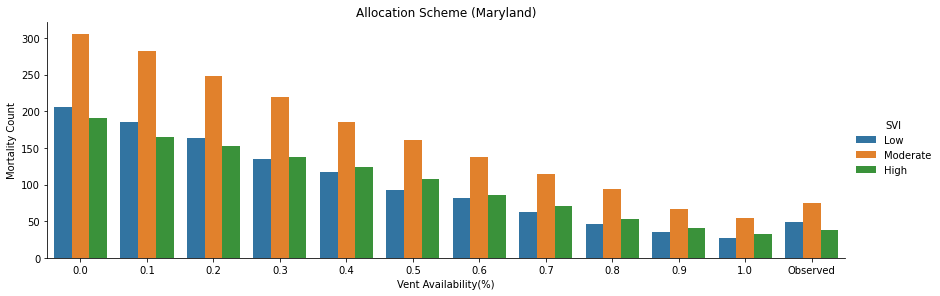

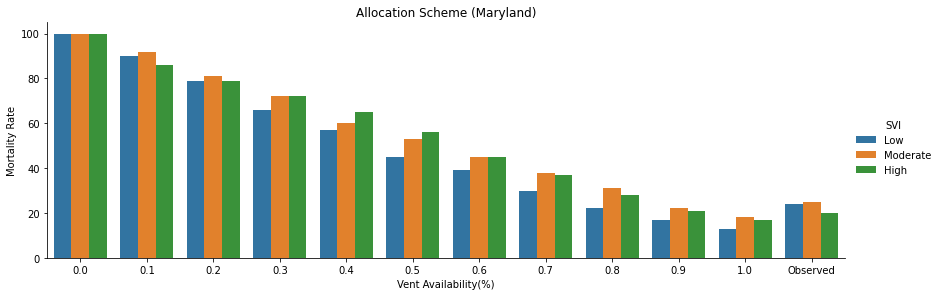

In [ ]:
visualize_count_mortality(df_base_maryland, 'Maryland')
visualize_percentage_mortality(df_base_maryland, 'Maryland')

## Max Lives Years

In [ ]:
ls_df_count_death = []

for pct in vent_availability:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_mortality_sofa)   # Generate Allocation object
    df_death = allocation.max_life_years()                                         # Prioritize patients following Maryland CSC
    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death.append(df_death)

df_max_lives_years = pd.concat(ls_df_count_death)
df_max_lives_years['type_allocation'] = 'Max Lives Years'
df_base_max_lives_years = pd.concat([death_base, df_max_lives_years])
df_base_max_lives_years[['count_death', 'avg_death', 'percentage_death']] = df_base_max_lives_years[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
0,28304,15,Male,Hispanic or Latino,Insured,75.93,34.95,0,0,0,85,NaN,NaN,78621,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
1,26059,17,Female,White,Insured,14.35,NaN,0,1,1,83,Home,NaN,78738,1768,48453001768,10404,484,4.7,143,2.7,59592,131,1.8,0.0382,0.1228,0.0396,0.4280,0.1010,0,0,0,0,0,Low,1,0
2,27960,18,Female,Hispanic or Latino,Insured,83.68,NaN,0,0,0,82,Home,NaN,78757,1707,48453001707,5111,389,7.6,59,2.0,47839,35,0.9,0.0539,0.2216,0.0534,0.3637,0.1183,0,0,0,0,0,Low,1,0
3,39514,19,Female,White,Insured,17.82,NaN,0,0,0,81,Home,NaN,78616,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
4,11893,20,Female,White,Insured,96.23,NaN,0,1,1,80,Home,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,19
1,High,1,21
2,Low,0,22
3,Low,1,24
4,Moderate,0,36
5,Moderate,1,25


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,19,0.48,1.0,0.48,0.48,19.20
1,High,1,21,0.52,0.0,0.00,0.48,19.20
2,Low,0,22,0.48,1.0,0.48,0.48,22.08
3,Low,1,24,0.52,0.0,0.00,0.48,22.08
4,Moderate,0,36,0.59,1.0,0.59,0.59,35.99
5,Moderate,1,25,0.41,0.0,0.00,0.59,35.99


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
147,13424,8,Female,Hispanic or Latino,Insured,25.40,NaN,1,1,2,92,Home,NaN,76574,20900,48491020900,4279,258,6.0,175,7.2,31594,236,7.9,0.3535,0.5284,0.1039,0.3255,0.2901,0,0,0,0,0,Low,1,0
148,23727,14,Male,Hispanic or Latino,Insured,38.48,NaN,1,1,1,86,Home,NaN,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
149,13500,16,Female,White,Insured,30.25,NaN,1,0,0,84,Home,NaN,78633,20115,48491020115,4790,192,4.0,40,2.3,41076,52,1.6,0.0457,0.7100,0.0450,0.0090,0.0369,0,1,0,0,1,Low,1,0
150,18415,18,Male,Hispanic or Latino,Insured,53.98,NaN,1,1,1,82,Home,NaN,78705,601,48453000601,10169,571,65.3,479,13.8,4686,10,2.4,0.8231,0.0036,0.2362,0.9248,0.4737,3,0,0,3,6,Moderate,1,0
151,40894,20,Female,White,Uninsured,23.15,NaN,1,0,0,80,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,151
1,Low,160
2,Moderate,245


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,170.20
2,Low,182.08
4,Moderate,280.99


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,1
1,High,1,39
2,Low,0,3
3,Low,1,43
4,Moderate,0,3
5,Moderate,1,58


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,1,0.02,1.0,0.02,0.02,0.80
1,High,1,39,0.98,0.0,0.00,0.02,0.80
2,Low,0,3,0.07,1.0,0.07,0.07,3.22
3,Low,1,43,0.93,0.0,0.00,0.07,3.22
4,Moderate,0,3,0.05,1.0,0.05,0.05,3.05
5,Moderate,1,58,0.95,0.0,0.00,0.05,3.05


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
147,13424,8,Female,Hispanic or Latino,Insured,25.40,NaN,1,1,2,92,Home,NaN,76574,20900,48491020900,4279,258,6.0,175,7.2,31594,236,7.9,0.3535,0.5284,0.1039,0.3255,0.2901,0,0,0,0,0,Low,1,0
148,23727,14,Male,Hispanic or Latino,Insured,38.48,NaN,1,1,1,86,Home,NaN,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
149,13500,16,Female,White,Insured,30.25,NaN,1,0,0,84,Home,NaN,78633,20115,48491020115,4790,192,4.0,40,2.3,41076,52,1.6,0.0457,0.7100,0.0450,0.0090,0.0369,0,1,0,0,1,Low,1,0
150,18415,18,Male,Hispanic or Latino,Insured,53.98,NaN,1,1,1,82,Home,NaN,78705,601,48453000601,10169,571,65.3,479,13.8,4686,10,2.4,0.8231,0.0036,0.2362,0.9248,0.4737,3,0,0,3,6,Moderate,1,0
151,40894,20,Female,White,Uninsured,23.15,NaN,1,0,0,80,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,151
1,Low,160
2,Moderate,245


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,151.80
2,Low,163.22
4,Moderate,248.05


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 1-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61


,cat_SVI,expected_death
0,High,0.0
1,Low,0.0
2,Moderate,0.0


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,3
1,High,1,15
2,Low,0,9
3,Low,1,23
4,Moderate,0,11
5,Moderate,1,25


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,3,0.17,1.0,0.17,0.17,3.06
1,High,1,15,0.83,0.0,0.00,0.17,3.06
2,Low,0,9,0.28,1.0,0.28,0.28,8.96
3,Low,1,23,0.72,0.0,0.00,0.28,8.96
4,Moderate,0,11,0.31,1.0,0.31,0.31,11.16
5,Moderate,1,25,0.69,0.0,0.00,0.31,11.16


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
233,33504,7,Male,Hispanic or Latino,Insured,79.15,NaN,2,1,1,93,Home,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
234,45331,20,Male,Hispanic or Latino,Insured,139.30,NaN,2,1,1,80,Home,NaN,78616,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
235,14719,24,Male,White,Uninsured,29.90,NaN,2,0,0,76,Home,NaN,78701,1100,48453001100,6608,890,13.8,76,1.5,109352,377,6.2,0.1301,0.0291,0.1295,0.8134,0.1809,0,0,0,2,2,Low,1,0
236,28150,29,Male,Black or African American,Uninsured,41.20,NaN,2,1,1,71,Home,NaN,78653,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
237,18668,30,Female,Black or African American,Insured,49.77,38.93,2,1,3,70,Home,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,133
1,Low,128
2,Moderate,209


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,136.06
2,Low,136.96
4,Moderate,220.16


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 3-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 6.4-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26


,cat_SVI,expected_death
0,High,0.58
1,Low,0.77
2,Moderate,1.66


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,15
1,High,1,1
2,Low,0,26
3,Moderate,0,25


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,15,0.94,1.00,0.9400,0.9436,15.0976
1,High,1,1,0.06,0.06,0.0036,0.9436,15.0976
2,Low,0,26,1.00,1.00,1.0000,1.0000,26.0000
3,Moderate,0,25,1.00,1.00,1.0000,1.0000,25.0000


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
347,33220,0,Female,Hispanic or Latino,Insured,17.80,NaN,4,0,0,100,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
348,15557,10,Male,Hispanic or Latino,Insured,863.32,1059.40,4,1,2,90,Home,NaN,78724,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
349,40112,17,Male,White,Insured,36.95,28.52,4,1,1,83,Home,NaN,78666,10905,48209010905,6751,329,4.9,141,4.0,34221,398,8.2,0.2124,0.3476,0.2701,0.3516,0.2417,0,0,0,0,0,Low,1,0
350,38948,19,Female,Hispanic or Latino,Insured,333.97,240.33,4,1,2,81,Home,NaN,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
351,19621,24,Male,White,Uninsured,7.56,1.27,4,0,0,76,Home,NaN,78656,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,108
1,Low,90
2,Moderate,158


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,123.6776
2,Low,116.7700
3,Moderate,184.6600


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,1.60
1,Low,2.43
2,Moderate,3.26


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,34
1,High,1,1
2,Low,0,19
3,Low,1,2
4,Moderate,0,35
5,Moderate,1,1


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,34,0.97,1.0,0.970,0.976,34.160
1,High,1,1,0.03,0.2,0.006,0.976,34.160
2,Low,0,19,0.90,1.0,0.900,0.920,19.320
3,Low,1,2,0.10,0.2,0.020,0.920,19.320
4,Moderate,0,35,0.97,1.0,0.970,0.976,35.136
5,Moderate,1,1,0.03,0.2,0.006,0.976,35.136


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
439,42071,17,Male,Hispanic or Latino,Insured,684.56,454.23,5,1,1,83,Home,NaN,78704,2307,48453002307,6264,1101,17.7,157,3.9,29346,700,15.8,0.4617,0.1511,0.6373,0.8199,0.5407,0,0,0,1,1,Moderate,1,0
440,14658,23,Male,Hispanic or Latino,Insured,47.32,21.08,5,0,0,77,Home,NaN,78613,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate,1,0
441,41743,25,Male,Hispanic or Latino,Insured,172.65,39.05,5,0,0,75,Home,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
442,49941,29,Female,White,Insured,789.70,775.33,5,0,0,71,Another Hospital,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
443,12184,32,Male,Hispanic or Latino,Insured,980.38,1186.03,5,0,0,68,Long Term Care Hospital,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,73
1,Low,69
2,Moderate,122


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,108.760
2,Low,90.750
4,Moderate,160.396


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,1.60
1,Low,2.43
2,Moderate,3.26


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,4
1,High,1,31
2,Low,0,7
3,Low,1,14
4,Moderate,0,7
5,Moderate,1,29


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,4,0.11,1.0,0.110,0.288,10.080
1,High,1,31,0.89,0.2,0.178,0.288,10.080
2,Low,0,7,0.33,1.0,0.330,0.464,9.744
3,Low,1,14,0.67,0.2,0.134,0.464,9.744
4,Moderate,0,7,0.19,1.0,0.190,0.352,12.672
5,Moderate,1,29,0.81,0.2,0.162,0.352,12.672


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
439,42071,17,Male,Hispanic or Latino,Insured,684.56,454.23,5,1,1,83,Home,NaN,78704,2307,48453002307,6264,1101,17.7,157,3.9,29346,700,15.8,0.4617,0.1511,0.6373,0.8199,0.5407,0,0,0,1,1,Moderate,1,0
440,14658,23,Male,Hispanic or Latino,Insured,47.32,21.08,5,0,0,77,Home,NaN,78613,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate,1,0
441,41743,25,Male,Hispanic or Latino,Insured,172.65,39.05,5,0,0,75,Home,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
442,49941,29,Female,White,Insured,789.70,775.33,5,0,0,71,Another Hospital,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
443,12184,32,Male,Hispanic or Latino,Insured,980.38,1186.03,5,0,0,68,Long Term Care Hospital,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,73
1,Low,69
2,Moderate,122


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,84.680
2,Low,81.174
4,Moderate,137.932


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 5-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,8.67
1,Low,6.67
2,Moderate,10.53


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,1
1,High,1,14
2,Low,0,5
3,Low,1,17
4,Moderate,0,3
5,Moderate,1,22


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,1,0.07,1.0,0.070,0.256,3.840
1,High,1,14,0.93,0.2,0.186,0.256,3.840
2,Low,0,5,0.23,1.0,0.230,0.384,8.448
3,Low,1,17,0.77,0.2,0.154,0.384,8.448
4,Moderate,0,3,0.12,1.0,0.120,0.296,7.400
5,Moderate,1,22,0.88,0.2,0.176,0.296,7.400


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
501,35901,18,Male,Hispanic or Latino,Insured,186.75,2.85,6,0,0,82,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
502,35114,25,Male,Hispanic or Latino,Insured,72.70,69.42,6,1,1,75,Another Hospital,6/23/2020 2:39,78621,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
503,26025,28,Male,Black or African American,Uninsured,53.73,19.15,6,0,0,72,Home,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0
504,35282,30,Male,Hispanic or Latino,Insured,227.40,226.17,6,0,0,70,Expired,7/25/2020 18:57,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
505,31965,42,Male,White,Insured,592.99,503.03,6,1,3,58,Long Term Care Hospital,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,58
1,Low,47
2,Moderate,97


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,70.510
2,Low,62.118
4,Moderate,114.930


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 7-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 21.5-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,15.36
1,Low,13.91
2,Moderate,19.66


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,3
1,High,1,5
2,Low,0,7
3,Low,1,3
4,Moderate,0,10
5,Moderate,1,4


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,3,0.38,1.00,0.3800,0.5102,4.0816
1,High,1,5,0.62,0.21,0.1302,0.5102,4.0816
2,Low,0,7,0.70,1.00,0.7000,0.7630,7.6300
3,Low,1,3,0.30,0.21,0.0630,0.7630,7.6300
4,Moderate,0,10,0.71,1.00,0.7100,0.7709,10.7926
5,Moderate,1,4,0.29,0.21,0.0609,0.7709,10.7926


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
582,19753,37,Male,White,Insured,450.15,NaN,8,0,0,63,Still a patient,NaN,78758,1805,48453001805,4675,1511,32.4,54,1.9,21702,744,24.2,0.6053,0.2306,0.8349,0.9875,0.7905,0,0,1,2,3,High,1,0
583,46058,37,Male,Hispanic or Latino,Insured,301.28,242.42,8,1,2,63,Home Care with Home Health,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
584,34789,45,Female,Hispanic or Latino,Insured,455.67,474.57,8,1,1,55,Expired,10/27/2020 18:40,78660,1840,48453001840,11694,1706,14.6,121,1.8,25594,1336,17.7,0.3992,0.4788,0.7473,0.5262,0.5330,0,0,0,0,0,Moderate,1,0
585,12236,45,Male,White,Insured,1158.00,805.53,8,1,2,55,Another Hospital,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
586,14844,46,Male,Hispanic or Latino,Uninsured,2691.02,2207.33,8,1,1,54,Rehab Care,NaN,78610,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
699,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
700,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
701,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0


,cat_SVI,expected_death
0,High,33
1,Low,24
2,Moderate,64


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,52.4416
2,Low,45.5400
4,Moderate,94.4526


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 9-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 33.3-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,20.74
1,Low,17.06
2,Moderate,29.00


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,4
1,High,1,4
2,Low,0,5
3,Low,1,5
4,Moderate,0,10
5,Moderate,1,8


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,4,0.50,1.00,0.5000,0.6650,5.3200
1,High,1,4,0.50,0.33,0.1650,0.6650,5.3200
2,Low,0,5,0.50,1.00,0.5000,0.6650,6.6500
3,Low,1,5,0.50,0.33,0.1650,0.6650,6.6500
4,Moderate,0,10,0.56,1.00,0.5600,0.7052,12.6936
5,Moderate,1,8,0.44,0.33,0.1452,0.7052,12.6936


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
651,44248,49,Male,White,Insured,57.74,44.05,10,1,5,51,Home Care with Home Health,NaN,78655,960500,48055960500,7736,2051,27.3,82,2.1,22239,838,20.5,0.5642,0.2339,0.5664,0.8979,0.6238,0,0,0,2,2,Moderate,1,0
652,12922,51,Male,Hispanic or Latino,Insured,484.28,482.64,10,1,3,49,Expired,8/20/2020 12:32,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
653,42261,56,Female,Hispanic or Latino,Insured,413.63,408.70,10,1,3,44,Expired,8/7/2020 15:41,78617,2435,48453002435,8640,1621,18.8,126,2.7,21313,1648,31.9,0.5943,0.7167,0.7519,0.4437,0.6371,0,1,0,1,2,Moderate,1,0
654,42261,56,Female,Hispanic or Latino,Insured,413.63,408.70,10,1,3,44,Expired,8/7/2020 15:41,78617,2435,48453002435,8640,1621,18.8,126,2.7,21313,1648,31.9,0.5943,0.7167,0.7519,0.4437,0.6371,0,1,0,1,2,Moderate,1,0
655,17790,58,Male,White,Insured,318.77,233.28,10,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
656,17347,60,Female,Hispanic or Latino,Insured,269.43,260.33,10,1,3,40,Expired,7/22/2020 17:15,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
657,35541,69,Male,Black or African American,Uninsured,1393.48,1336.90,10,1,1,31,Expired,8/25/2020 18:47,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
658,46873,69,Female,Asian,Insured,629.97,617.02,10,1,1,31,Expired,7/29/2020 11:55,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
659,28506,69,Male,Hispanic or Latino,Insured,745.68,736.98,10,1,2,31,Expired,9/10/2020 7:11,78748,2421,48453002421,10705,1469,13.7,183,2.7,32881,607,8.0,0.2606,0.0906,0.4744,0.8463,0.3938,0,0,0,0,0,Moderate,1,0
660,41218,74,Female,Hispanic or Latino,Insured,436.15,436.67,10,1,2,26,Expired,8/14/2020 12:34,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0


,cat_SVI,expected_death
0,High,14
1,Low,11
2,Moderate,27


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,40.0600
2,Low,34.7100
4,Moderate,68.6936


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
METHOD: MORTALITY_ALLOCATED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


In [ ]:
#df_max_lives_years_tb = df_baseline_max_lives_years.loc[df_baseline_max_lives_years['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
df_max_lives_years_tb = df_base_max_lives_years.loc[df_base_max_lives_years['level']!=2.0, ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_max_lives_years_tb)

,SVI,count_death,level,type_allocation
0,High,191,0.0,Max Lives Years
1,Low,206,0.0,Max Lives Years
2,Moderate,306,0.0,Max Lives Years
0,High,170,0.1,Max Lives Years
2,Low,182,0.1,Max Lives Years
4,Moderate,281,0.1,Max Lives Years
0,High,152,0.2,Max Lives Years
2,Low,163,0.2,Max Lives Years
4,Moderate,248,0.2,Max Lives Years
0,High,136,0.3,Max Lives Years


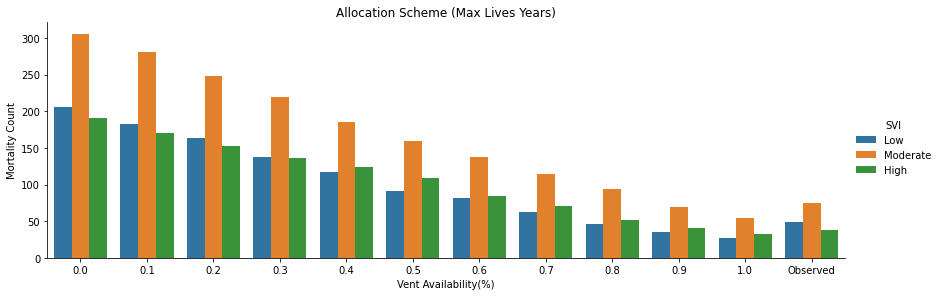

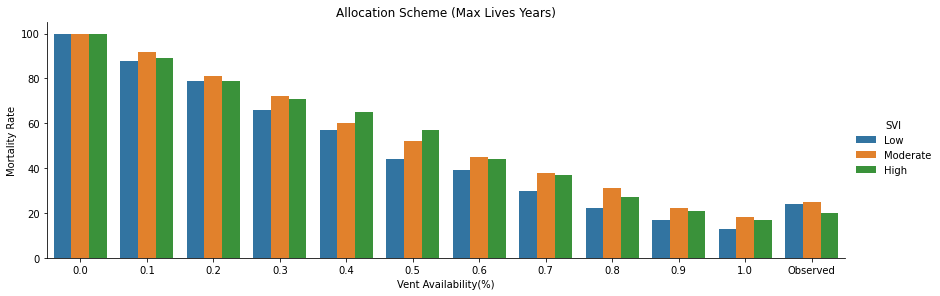

In [ ]:
visualize_count_mortality(df_base_max_lives_years, 'Max Lives Years')
visualize_percentage_mortality(df_base_max_lives_years, 'Max Lives Years')

## Youngest First

In [ ]:
ls_df_count_death = []

for pct in vent_availability:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_mortality_sofa)   # Generate Allocation object
    df_death = allocation.youngest()                                         # Prioritize patients following Maryland CSC
    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death.append(df_death)

df_youngest = pd.concat(ls_df_count_death)
df_youngest['type_allocation'] = 'Youngest'
df_base_youngest = pd.concat([death_base, df_youngest])
df_base_youngest[['count_death', 'avg_death', 'percentage_death']] = df_base_youngest[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
0,33220,0,Female,Hispanic or Latino,Insured,17.80,NaN,4,0,0,100,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
1,30021,5,Female,Black or African American,Uninsured,44.47,48.78,3,0,0,95,Expired,NaN,78207,170200,48029170200,5507,2354,42.7,263,12.2,11186,1818,51.4,0.9948,0.9724,0.9348,0.9591,0.9969,4,2,1,1,8,High,1,0
2,33504,7,Male,Hispanic or Latino,Insured,79.15,NaN,2,1,1,93,Home,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
3,28472,8,Male,Hispanic or Latino,Insured,239.22,NaN,3,0,0,92,Home,NaN,78621,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
4,13424,8,Female,Hispanic or Latino,Insured,25.40,NaN,1,1,2,92,Home,NaN,76574,20900,48491020900,4279,258,6.0,175,7.2,31594,236,7.9,0.3535,0.5284,0.1039,0.3255,0.2901,0,0,0,0,0,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,8
1,0,Low,6
2,0,Moderate,6
3,1,High,2
4,1,Low,7
5,1,Moderate,5
6,2,High,2
7,2,Low,2
8,2,Moderate,2
9,3,High,2


,cat_SVI,expected_death
0,High,2.38
1,Low,1.21
2,Moderate,2.78


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
70,12184,32,Male,Hispanic or Latino,Insured,980.38,1186.03,5,0,0,68,Long Term Care Hospital,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
71,17449,32,Male,Hispanic or Latino,Uninsured,41.30,NaN,0,1,1,68,Skilled Nursing Care,NaN,78616,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
72,43840,32,Male,Hispanic or Latino,Uninsured,66.17,11.08,1,0,0,68,Home,NaN,78745,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
73,23131,33,Female,Hispanic or Latino,Uninsured,22.87,NaN,2,1,1,67,Home,NaN,78616,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
74,11113,33,Male,Black or African American,Insured,108.27,NaN,0,1,1,67,Home,NaN,78634,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,168
1,Low,185
2,Moderate,280


,cat_SVI,expected_death
0,High,170.38
1,Low,186.21
2,Moderate,282.78


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,17
1,0,Low,10
2,0,Moderate,16
3,1,High,4
4,1,Low,7
5,1,Moderate,7
6,2,High,2
7,2,Low,2
8,2,Moderate,9
9,3,High,4


,cat_SVI,expected_death
0,High,6.08
1,Low,4.23
2,Moderate,5.05


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
140,18247,42,Female,Black or African American,Uninsured,66.92,NaN,0,1,2,58,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
141,49618,42,Male,Hispanic or Latino,Uninsured,234.37,NaN,0,0,0,58,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
142,23463,43,Male,White,Uninsured,1298.77,1382.18,3,1,2,57,Long Term Care Hospital,NaN,78756,1505,48453001505,4661,417,9.0,69,2.1,48385,103,2.9,0.0875,0.0354,0.0145,0.4322,0.0695,0,0,0,0,0,Low,1,0
143,31763,43,Male,Black or African American,Insured,495.78,507.80,1,1,1,57,Home Care with Home Health,NaN,78722,306,48453000306,5520,739,13.5,115,3.2,56024,185,4.6,0.1792,0.0312,0.4040,0.7715,0.2494,0,0,0,1,1,Low,1,0
144,11330,43,Male,Hispanic or Latino,Uninsured,164.80,NaN,3,0,0,57,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,141
1,Low,172
2,Moderate,250


,cat_SVI,expected_death
0,High,147.08
1,Low,176.23
2,Moderate,255.05


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,21
1,0,Low,19
2,0,Moderate,21
3,1,High,6
4,1,Low,11
5,1,Moderate,7
6,2,High,3
7,2,Low,2
8,2,Moderate,10
9,3,High,8


,cat_SVI,expected_death
0,High,8.36
1,Low,7.81
2,Moderate,10.30


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
210,31072,50,Male,White,Insured,72.90,NaN,5,1,2,50,Still a patient,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
211,29983,51,Male,Hispanic or Latino,Insured,40.70,NaN,0,1,2,49,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
212,35733,51,Female,White,Insured,1913.75,1695.54,4,1,1,49,Long Term Care Hospital,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
213,22123,51,Female,White,Insured,40.12,NaN,1,1,3,49,Home,NaN,78610,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
214,49078,51,Male,White,Insured,83.23,66.15,6,1,1,49,Against Medical Advice,NaN,78701,1100,48453001100,6608,890,13.8,76,1.5,109352,377,6.2,0.1301,0.0291,0.1295,0.8134,0.1809,0,0,0,2,2,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,121
1,Low,148
2,Moderate,224


,cat_SVI,expected_death
0,High,129.36
1,Low,155.81
2,Moderate,234.30


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,22
1,0,Low,26
2,0,Moderate,29
3,1,High,7
4,1,Low,11
5,1,Moderate,10
6,2,High,4
7,2,Low,2
8,2,Moderate,14
9,3,High,8


,cat_SVI,expected_death
0,High,12.03
1,Low,9.26
2,Moderate,19.46


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
281,16897,55,Female,Hispanic or Latino,Uninsured,39.67,NaN,0,0,0,45,Still a patient,NaN,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
282,15839,55,Male,White,Insured,106.60,NaN,1,1,1,45,Home,NaN,78619,10902,48209010902,16498,872,5.3,264,2.8,37674,323,3.0,0.1007,0.1163,0.1875,0.2705,0.1112,0,0,0,0,0,Low,1,0
283,13701,55,Female,White,Insured,25.10,NaN,2,0,0,45,Another Hospital,NaN,75839,950100,48225950100,5172,1024,20.2,38,1.6,21454,513,14.1,0.4627,0.5411,0.0819,0.3871,0.3516,0,1,0,1,2,Moderate,1,0
284,38165,56,Female,White,Insured,125.62,62.85,5,1,2,44,Home Care with Home Health,NaN,78666,10905,48209010905,6751,329,4.9,141,4.0,34221,398,8.2,0.2124,0.3476,0.2701,0.3516,0.2417,0,0,0,0,0,Low,1,0
285,34707,56,Male,Hispanic or Latino,Insured,295.38,303.88,11,1,1,44,Expired,11/15/2020 12:45,79029,950100,48341950100,2126,312,14.7,66,6.7,24532,337,25.9,0.6546,0.7435,0.5430,0.3037,0.5685,0,0,0,0,0,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,104
1,Low,134
2,Moderate,184


,cat_SVI,expected_death
0,High,116.03
1,Low,143.26
2,Moderate,203.46


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 2-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 6.4-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,3,High,1
1,4,High,1


,cat_SVI,expected_death
0,High,0.26


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,80
1,High,1,109
2,Low,0,116
3,Low,1,87
4,Moderate,0,152
5,Moderate,1,153


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,80,0.42,1.00,0.4200,0.4548,85.9572
1,High,1,109,0.58,0.06,0.0348,0.4548,85.9572
2,Low,0,116,0.57,1.00,0.5700,0.5958,120.9474
3,Low,1,87,0.43,0.06,0.0258,0.5958,120.9474
4,Moderate,0,152,0.50,1.00,0.5000,0.5300,161.6500
5,Moderate,1,153,0.50,0.06,0.0300,0.5300,161.6500


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0
702,38186,100,Female,Black or African American,Insured,51.08,NaN,1,1,2,0,Expired,4/14/2020 16:17,78722,306,48453000306,5520,739,13.5,115,3.2,56024,185,4.6,0.1792,0.0312,0.4040,0.7715,0.2494,0,0,0,1,1,Low,1,0


,cat_SVI,expected_death
0,Low,3
1,Moderate,1


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,86.2172
2,Low,123.9474
4,Moderate,162.6500


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,29
1,0,Low,34
2,0,Moderate,40
3,1,High,7
4,1,Low,16
5,1,Moderate,15
6,2,High,7
7,2,Low,5
8,2,Moderate,18
9,3,High,12


,cat_SVI,expected_death
0,High,20.90
1,Low,12.68
2,Moderate,31.95


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
421,41028,64,Male,Hispanic or Latino,Insured,86.35,37.95,12,1,5,36,Home,NaN,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
422,25452,64,Male,Hispanic or Latino,Insured,114.73,NaN,2,1,2,36,Home,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
423,19001,64,Female,Hispanic or Latino,Insured,82.50,NaN,1,0,0,36,Home,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
424,42127,64,Female,Hispanic or Latino,Insured,59.57,116.40,12,1,3,36,Expired,7/16/2020 1:03,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
425,49072,64,Male,Hispanic or Latino,Insured,475.25,470.52,11,1,1,36,Expired,8/3/2020 15:50,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,60
1,Low,98
2,Moderate,124


,cat_SVI,expected_death
0,High,80.90
1,Low,110.68
2,Moderate,155.95


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,30
1,0,Low,37
2,0,Moderate,52
3,1,High,11
4,1,Low,18
5,1,Moderate,20
6,2,High,8
7,2,Low,7
8,2,Moderate,21
9,3,High,13


,cat_SVI,expected_death
0,High,23.49
1,Low,15.52
2,Moderate,39.32


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
492,46659,69,Male,Hispanic or Latino,Insured,7.10,2.32,5,1,2,31,Expired,9/1/2020 23:10,78666,10905,48209010905,6751,329,4.9,141,4.0,34221,398,8.2,0.2124,0.3476,0.2701,0.3516,0.2417,0,0,0,0,0,Low,1,0
493,41187,69,Female,Asian,Insured,24.97,NaN,4,1,4,31,Expired,8/6/2020 3:15,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0
494,35541,69,Male,Black or African American,Uninsured,1393.48,1336.90,10,1,1,31,Expired,8/25/2020 18:47,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
495,35136,69,Female,Black or African American,Insured,309.54,242.68,5,1,1,31,Expired,7/7/2020 16:31,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0
496,44660,69,Female,Hispanic or Latino,Insured,25.50,NaN,0,1,3,31,Home,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,43
1,Low,83
2,Moderate,85


,cat_SVI,expected_death
0,High,66.49
1,Low,98.52
2,Moderate,124.32


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,33
1,0,Low,40
2,0,Moderate,57
3,1,High,15
4,1,Low,22
5,1,Moderate,25
6,2,High,8
7,2,Low,8
8,2,Moderate,22
9,3,High,13


,cat_SVI,expected_death
0,High,25.76
1,Low,19.85
2,Moderate,44.97


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
562,26915,73,Male,Black or African American,Insured,81.28,NaN,3,1,4,27,Expired,8/1/2020 16:23,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
563,30090,73,Female,White,Insured,342.73,93.05,9,1,1,27,Expired,9/12/2020 8:10,78626,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
564,11432,73,Male,White,Insured,47.30,NaN,3,1,2,27,Home Care with Home Health,NaN,78746,1916,48453001916,3045,49,1.6,48,3.5,79467,22,1.2,0.0294,0.1090,0.2276,0.0059,0.0063,0,1,0,0,1,Low,1,0
565,48031,73,Female,White,Insured,18.45,NaN,2,1,2,27,Home Care with Home Health,NaN,78746,1916,48453001916,3045,49,1.6,48,3.5,79467,22,1.2,0.0294,0.1090,0.2276,0.0059,0.0063,0,1,0,0,1,Low,1,0
566,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,30
1,Low,53
2,Moderate,58


,cat_SVI,expected_death
0,High,55.76
1,Low,72.85
2,Moderate,102.97


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,0,High,39
1,0,Low,43
2,0,Moderate,60
3,1,High,15
4,1,Low,25
5,1,Moderate,29
6,2,High,8
7,2,Low,12
8,2,Moderate,24
9,3,High,14


,cat_SVI,expected_death
0,High,30.59
1,Low,23.61
2,Moderate,49.94


METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
632,27408,80,Male,White,Insured,34.68,22.68,9,1,3,20,Expired,7/22/2020 11:32,78628,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
633,32708,80,Female,White,Insured,221.67,213.10,5,1,3,20,Expired,10/16/2020 13:18,78605,960400,48053960400,5508,762,13.8,34,1.5,35346,508,12.0,0.2531,0.8449,0.0819,0.1425,0.2408,0,2,0,0,2,Low,1,0
634,33613,81,Female,Hispanic or Latino,Insured,139.97,NaN,6,1,2,19,Skilled Nursing Care,NaN,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
635,31296,81,Male,White,Insured,130.27,NaN,1,1,4,19,Skilled Nursing Care,NaN,78662,960102,48055960102,4287,542,13.0,51,2.9,24053,295,10.3,0.3675,0.4333,0.2502,0.7027,0.4336,0,0,0,1,1,Moderate,1,0
636,45023,81,Male,White,Insured,96.70,NaN,5,1,1,19,Expired,6/1/2020 20:37,77835,170200,48477170200,6936,982,14.6,107,3.4,27234,501,11.6,0.3874,0.7943,0.2328,0.8757,0.5877,0,0,0,0,0,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,12333,93,Female,Hispanic or Latino,Insured,21.65,NaN,2,1,1,7,Skilled Nursing Care,NaN,78702,2109,48453002109,4314,815,19.0,23,0.9,27399,590,18.0,0.4064,0.1952,0.5484,0.9045,0.5492,0,0,0,1,1,Moderate,1,0
699,38437,94,Male,White,Insured,255.18,247.35,5,1,1,6,Expired,7/19/2020 18:20,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
700,25087,94,Male,Hispanic or Latino,Insured,190.41,26.67,11,1,2,6,Expired,8/13/2020 14:09,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
701,26729,95,Female,White,Insured,59.48,NaN,3,1,2,5,Expired,7/1/2020 22:10,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low,1,0


,cat_SVI,expected_death
0,High,14
1,Low,28
2,Moderate,29


,cat_SVI,expected_death
0,High,44.59
1,Low,51.61
2,Moderate,78.94


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
METHOD: MORTALITY_ALLOCATED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


In [ ]:
df_youngest_tb = df_base_youngest.loc[df_base_youngest['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_youngest_tb)

,SVI,count_death,level,type_allocation
0,Low,49,2.0,Baseline
1,Moderate,75,2.0,Baseline
2,High,38,2.0,Baseline
0,High,191,0.0,Youngest
1,Low,206,0.0,Youngest
2,Moderate,306,0.0,Youngest
0,High,170,0.1,Youngest
1,Low,186,0.1,Youngest
2,Moderate,283,0.1,Youngest
0,High,147,0.2,Youngest


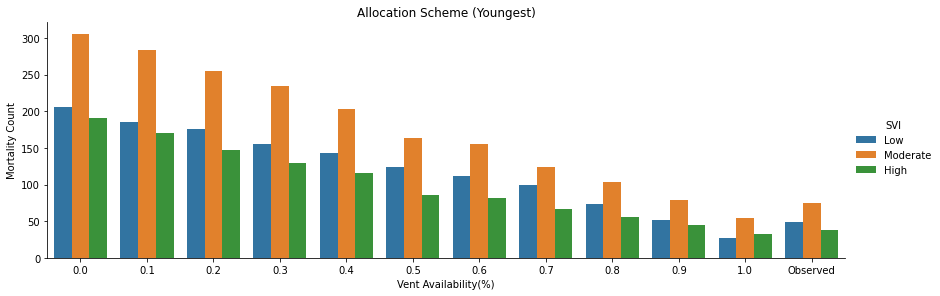

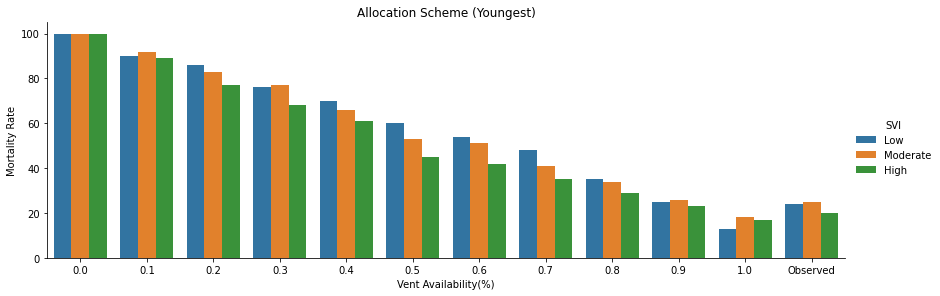

In [ ]:
visualize_count_mortality(df_base_youngest, 'Youngest')
visualize_percentage_mortality(df_base_youngest, 'Youngest')

## Sickest First

In [ ]:
ls_df_count_death = []

for pct in vent_availability:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_mortality_sofa)   # Generate Allocation object
    df_death = allocation.sickest()                                         # Prioritize patients following Maryland CSC
    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death.append(df_death)

df_sickest = pd.concat(ls_df_count_death)
df_sickest['type_allocation'] = 'Sickest'
df_base_sickest = pd.concat([death_base, df_sickest])
df_base_sickest[['count_death', 'avg_death', 'percentage_death']] = df_base_sickest[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)


------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
0,32723,74,Male,White,Insured,30.60,18.44,19,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
1,32723,74,Male,White,Insured,30.60,18.44,17,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
2,32723,74,Male,White,Insured,30.60,18.44,15,1,2,26,Expired,11/5/2020 16:40,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
3,17790,58,Male,White,Insured,318.77,233.28,14,1,1,42,NaN,NaN,78639,960500,48053960500,6358,758,11.9,175,6.0,27453,528,12.3,0.4711,0.5497,0.3483,0.6075,0.4921,0,0,0,0,0,Moderate,1,0
4,33610,72,Male,Black or African American,Insured,138.79,51.37,14,1,1,28,Still a patient,NaN,78725,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


,cat_SVI,expected_death
0,High,191
1,Low,206
2,Moderate,306


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 9-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 33.3-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,10,High,4
1,10,Low,2
2,10,Moderate,5
3,11,High,4
4,11,Low,6
5,11,Moderate,9
6,12,High,1
7,12,Moderate,8
8,13,High,2
9,13,Low,3


,cat_SVI,expected_death
0,High,9.70
1,Low,6.86
2,Moderate,19.38


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,2
1,High,1,6
2,Low,0,3
3,Low,1,7
4,Moderate,0,13
5,Moderate,1,5


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,2,0.25,1.00,0.2500,0.4975,3.9800
1,High,1,6,0.75,0.33,0.2475,0.4975,3.9800
2,Low,0,3,0.30,1.00,0.3000,0.5310,5.3100
3,Low,1,7,0.70,0.33,0.2310,0.5310,5.3100
4,Moderate,0,13,0.72,1.00,0.7200,0.8124,14.6232
5,Moderate,1,5,0.28,0.33,0.0924,0.8124,14.6232


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
88,41528,57,Female,Hispanic or Latino,Insured,929.56,1067.32,8,1,4,43,Expired,9/1/2020 10:23,78610,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
89,13682,63,Female,Black or African American,Insured,519.21,231.40,8,1,3,37,Long Term Care Hospital,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
90,39033,57,Male,White,Insured,1023.72,993.53,8,1,2,43,Long Term Care Hospital,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0
91,20192,54,Male,Hispanic or Latino,Insured,365.94,367.41,8,1,3,46,Expired,8/13/2020 20:54,78640,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
92,12271,57,Male,Black or African American,Insured,526.73,528.28,8,1,2,43,Expired,7/27/2020 11:52,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,169
1,Low,185
2,Moderate,261


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,182.6800
2,Low,197.1700
4,Moderate,295.0032


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 7-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 21.5-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,8,High,11
1,8,Low,3
2,8,Moderate,19
3,9,High,8
4,9,Low,10
5,9,Moderate,18
6,10,High,4
7,10,Low,2
8,10,Moderate,5
9,11,High,4


,cat_SVI,expected_death
0,High,16.02
1,Low,11.19
2,Moderate,31.70


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,1,8
1,Low,0,5
2,Low,1,5
3,Moderate,0,8
4,Moderate,1,6


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,1,8,1.00,0.21,0.2100,0.2100,1.6800
1,Low,0,5,0.50,1.00,0.5000,0.6050,6.0500
2,Low,1,5,0.50,0.21,0.1050,0.6050,6.0500
3,Moderate,0,8,0.57,1.00,0.5700,0.6603,9.2442
4,Moderate,1,6,0.43,0.21,0.0903,0.6603,9.2442


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
153,44013,60,Female,Black or African American,Insured,293.63,299.13,6,1,3,40,Expired,6/12/2020 16:03,78948,200,48287000200,2818,306,10.9,37,2.6,30118,584,27.3,0.3940,0.5848,0.4097,0.2801,0.3790,0,2,0,1,3,Moderate,1,0
154,43833,49,Female,Hispanic or Latino,Uninsured,176.77,314.87,6,0,0,51,Still a patient,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
155,34577,48,Male,Hispanic or Latino,Insured,304.25,303.75,6,1,3,52,Expired,7/8/2020 22:01,78621,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
156,22664,58,Male,Hispanic or Latino,Uninsured,113.61,NaN,6,0,0,42,Home,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
157,40309,62,Male,Hispanic or Latino,Insured,284.17,100.05,6,1,3,38,Expired,6/26/2020 15:00,78644,960101,48055960101,7238,960,13.3,92,2.7,24231,1539,36.0,0.5170,0.4827,0.7179,0.6196,0.6058,0,0,0,2,2,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,150
1,Low,172
2,Moderate,228


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,167.7000
1,Low,189.2400
3,Moderate,268.9442


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 5-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,6,High,17
1,6,Low,13
2,6,Moderate,19
3,7,High,8
4,7,Low,10
5,7,Moderate,14
6,8,High,11
7,8,Low,3
8,8,Moderate,19
9,9,High,8


,cat_SVI,expected_death
0,High,21.40
1,Low,16.14
2,Moderate,38.79


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,13
1,High,1,2
2,Low,0,22
3,Moderate,0,19
4,Moderate,1,6


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,13,0.87,1.0,0.870,0.896,13.44
1,High,1,2,0.13,0.2,0.026,0.896,13.44
2,Low,0,22,1.00,1.0,1.000,1.000,22.00
3,Moderate,0,19,0.76,1.0,0.760,0.808,20.20
4,Moderate,1,6,0.24,0.2,0.048,0.808,20.20


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
264,33220,0,Female,Hispanic or Latino,Insured,17.80,NaN,4,0,0,100,Home,NaN,78753,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
265,15345,55,Male,White,Insured,336.42,327.77,4,1,2,45,Expired,4/17/2020 14:08,78602,950802,48021950802,7625,1011,13.3,334,8.6,21691,1023,24.8,0.7098,0.5127,0.6940,0.2269,0.5570,0,1,0,1,2,Moderate,1,0
266,25018,28,Female,Hispanic or Latino,Insured,532.52,NaN,4,1,3,72,Home Care with Home Health,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
267,36869,56,Female,Hispanic or Latino,Uninsured,186.04,77.70,4,0,0,44,Home,NaN,78744,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High,1,0
268,45813,82,Male,Hispanic or Latino,Insured,17.97,NaN,4,1,4,18,Home,NaN,78724,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,118
1,Low,137
2,Moderate,184


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,152.84
2,Low,175.14
3,Moderate,242.99


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,5,High,15
1,5,Low,22
2,5,Moderate,25
3,6,High,17
4,6,Low,13
5,6,Moderate,19
6,7,High,8
7,7,Low,10
8,7,Moderate,14
9,8,High,11


,cat_SVI,expected_death
0,High,24.43
1,Low,20.58
2,Moderate,43.84


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,29
1,High,1,6
2,Low,0,17
3,Low,1,4
4,Moderate,0,29
5,Moderate,1,7


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,29,0.83,1.0,0.830,0.864,30.240
1,High,1,6,0.17,0.2,0.034,0.864,30.240
2,Low,0,17,0.81,1.0,0.810,0.848,17.808
3,Low,1,4,0.19,0.2,0.038,0.848,17.808
4,Moderate,0,29,0.81,1.0,0.810,0.848,30.528
5,Moderate,1,7,0.19,0.2,0.038,0.848,30.528


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
356,45607,62,Male,White,Insured,105.07,NaN,3,1,1,38,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
357,44009,42,Male,Hispanic or Latino,Uninsured,38.27,NaN,3,0,0,58,Home,NaN,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
358,10870,70,Female,White,Insured,172.38,NaN,3,1,3,30,Expired,7/21/2020 14:32,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
359,35834,38,Male,Hispanic or Latino,Insured,368.50,334.60,3,1,1,62,Rehab Care,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
360,30021,5,Female,Black or African American,Uninsured,44.47,48.78,3,0,0,95,Expired,NaN,78207,170200,48029170200,5507,2354,42.7,263,12.2,11186,1818,51.4,0.9948,0.9724,0.9348,0.9591,0.9969,4,2,1,1,8,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,83
1,Low,116
2,Moderate,148


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,137.670
2,Low,154.388
4,Moderate,222.368


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 4-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 20.2-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,5,High,15
1,5,Low,22
2,5,Moderate,25
3,6,High,17
4,6,Low,13
5,6,Moderate,19
6,7,High,8
7,7,Low,10
8,7,Moderate,14
9,8,High,11


,cat_SVI,expected_death
0,High,24.43
1,Low,20.58
2,Moderate,43.84


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,1
1,High,1,34
2,Low,0,1
3,Low,1,20
4,Moderate,0,3
5,Moderate,1,33


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,1,0.03,1.0,0.030,0.224,7.840
1,High,1,34,0.97,0.2,0.194,0.224,7.840
2,Low,0,1,0.05,1.0,0.050,0.240,5.040
3,Low,1,20,0.95,0.2,0.190,0.240,5.040
4,Moderate,0,3,0.08,1.0,0.080,0.264,9.504
5,Moderate,1,33,0.92,0.2,0.184,0.264,9.504


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
356,45607,62,Male,White,Insured,105.07,NaN,3,1,1,38,Home,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
357,44009,42,Male,Hispanic or Latino,Uninsured,38.27,NaN,3,0,0,58,Home,NaN,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
358,10870,70,Female,White,Insured,172.38,NaN,3,1,3,30,Expired,7/21/2020 14:32,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
359,35834,38,Male,Hispanic or Latino,Insured,368.50,334.60,3,1,1,62,Rehab Care,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low,1,0
360,30021,5,Female,Black or African American,Uninsured,44.47,48.78,3,0,0,95,Expired,NaN,78207,170200,48029170200,5507,2354,42.7,263,12.2,11186,1818,51.4,0.9948,0.9724,0.9348,0.9591,0.9969,4,2,1,1,8,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,83
1,Low,116
2,Moderate,148


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,115.270
2,Low,141.620
4,Moderate,201.344


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 3-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 6.4-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,4,High,35
1,4,Low,21
2,4,Moderate,36
3,5,High,15
4,5,Low,22
5,5,Moderate,25
6,6,High,17
7,6,Low,13
8,6,Moderate,19
9,7,High,8


,cat_SVI,expected_death
0,High,31.50
1,Low,24.82
2,Moderate,51.11


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,1,16
1,Low,0,1
2,Low,1,25
3,Moderate,0,1
4,Moderate,1,24


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,1,16,1.00,0.06,0.0600,0.0600,0.9600
1,Low,0,1,0.04,1.00,0.0400,0.0976,2.5376
2,Low,1,25,0.96,0.06,0.0576,0.0976,2.5376
3,Moderate,0,1,0.04,1.00,0.0400,0.0976,2.4400
4,Moderate,1,24,0.96,0.06,0.0576,0.0976,2.4400


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
423,21784,89,Male,Black or African American,Insured,4.37,NaN,2,1,3,11,Hospice Facility,9/5/2020 16:43,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0
424,48031,73,Female,White,Insured,18.45,NaN,2,1,2,27,Home Care with Home Health,NaN,78746,1916,48453001916,3045,49,1.6,48,3.5,79467,22,1.2,0.0294,0.1090,0.2276,0.0059,0.0063,0,1,0,0,1,Low,1,0
425,23128,58,Male,Hispanic or Latino,Uninsured,171.73,NaN,2,1,3,42,Skilled Nursing Care,NaN,78724,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
426,45920,41,Male,Hispanic or Latino,Uninsured,55.75,NaN,2,1,3,59,Home,NaN,78724,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate,1,0
427,10869,63,Male,Hispanic or Latino,Uninsured,80.30,NaN,2,1,1,37,Skilled Nursing Care,NaN,78752,1813,48453001813,7423,2425,32.8,168,4.2,20615,1531,33.7,0.7524,0.6154,0.8948,0.8684,0.8543,0,0,1,0,1,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,67
1,Low,90
2,Moderate,123


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,99.4600
1,Low,117.3576
3,Moderate,176.5500


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 1-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,2,High,9
1,2,Low,12
2,2,Moderate,26
3,3,High,16
4,3,Low,26
5,3,Moderate,25
6,4,High,35
7,4,Low,21
8,4,Moderate,36
9,5,High,15


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,13
1,High,1,5
2,Low,0,25
3,Low,1,7
4,Moderate,0,26
5,Moderate,1,10


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,13,0.72,1.0,0.72,0.72,12.96
1,High,1,5,0.28,0.0,0.00,0.72,12.96
2,Low,0,25,0.78,1.0,0.78,0.78,24.96
3,Low,1,7,0.22,0.0,0.00,0.78,24.96
4,Moderate,0,26,0.72,1.0,0.72,0.72,25.92
5,Moderate,1,10,0.28,0.0,0.00,0.72,25.92


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent
556,29126,73,Male,White,Insured,224.03,NaN,0,1,1,27,Skilled Nursing Care,NaN,78613,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate,1,0
557,39046,58,Male,Hispanic or Latino,Insured,158.79,NaN,0,1,1,42,Home,NaN,78959,960600,48055960600,2256,90,4.0,51,4.2,42545,159,9.4,0.1844,0.5974,0.1767,0.0999,0.1669,0,1,0,1,2,Low,1,0
558,26059,17,Female,White,Insured,14.35,NaN,0,1,1,83,Home,NaN,78738,1768,48453001768,10404,484,4.7,143,2.7,59592,131,1.8,0.0382,0.1228,0.0396,0.4280,0.1010,0,0,0,0,0,Low,1,0
559,45193,70,Male,White,Insured,48.71,NaN,0,1,3,30,Home,NaN,77475,750200,48089750200,1947,240,12.4,48,4.5,28912,266,18.9,0.4583,0.6351,0.3466,0.3792,0.4339,0,1,0,0,1,Moderate,1,0
560,11893,20,Female,White,Insured,96.23,NaN,0,1,1,80,Home,NaN,78723,1811,48453001811,3535,1089,30.8,71,3.7,22820,622,26.3,0.6676,0.6640,0.8183,0.6401,0.7277,0,0,1,1,2,High,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,17252,48,Male,White,Insured,137.82,NaN,0,1,2,52,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
699,47687,39,Female,White,Insured,30.02,NaN,0,0,0,61,Home,NaN,78641,20604,48491020604,6692,192,2.9,183,5.6,38224,83,1.9,0.1656,0.2436,0.1928,0.1070,0.1083,0,0,0,0,0,Low,1,0
700,39176,29,Male,White,Uninsured,47.92,NaN,0,1,1,71,Home,NaN,78727,1848,48453001848,5373,335,6.2,231,6.7,38344,419,9.9,0.3234,0.1143,0.6502,0.2862,0.2919,0,0,0,0,0,Low,1,0
701,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High,1,0


,cat_SVI,expected_death
0,High,40
1,Low,46
2,Moderate,61


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,86.06
2,Low,98.21
4,Moderate,141.29


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,1,High,18
1,1,Low,32
2,1,Moderate,36
3,2,High,9
4,2,Low,12
5,2,Moderate,26
6,3,High,16
7,3,Low,26
8,3,Moderate,25
9,4,High,35


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,38
1,High,1,2
2,Low,0,44
3,Low,1,2
4,Moderate,0,59
5,Moderate,1,2


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,38,0.95,1.0,0.95,0.95,38.00
1,High,1,2,0.05,0.0,0.00,0.95,38.00
2,Low,0,44,0.96,1.0,0.96,0.96,44.16
3,Low,1,2,0.04,0.0,0.00,0.96,44.16
4,Moderate,0,59,0.97,1.0,0.97,0.97,59.17
5,Moderate,1,2,0.03,0.0,0.00,0.97,59.17


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent


,cat_SVI,expected_death


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,71.10
2,Low,71.41
4,Moderate,113.54


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs-----------------------------------
-----------------------------------TIE SOFA: 0-----------------------------------
-----------------------------------MORTALITY PROBABILITY: 0.0-----------------------------------
-----------------------------------ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED


,SOFA,cat_SVI,count
0,1,High,18
1,1,Low,32
2,1,Moderate,36
3,2,High,9
4,2,Low,12
5,2,Moderate,26
6,3,High,16
7,3,Low,26
8,3,Moderate,25
9,4,High,35


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


-----------------------------------TIE-----------------------------------
METHOD: MORTALITY_TIE


,cat_SVI,vent,count
0,High,0,15
1,High,1,25
2,Low,0,33
3,Low,1,13
4,Moderate,0,23
5,Moderate,1,38


,cat_SVI,vent,count,P[NV] & P[V],P[D|NV] & P[D|V],P[D_sub],P[D_total],expected_death
0,High,0,15,0.38,1.0,0.38,0.38,15.20
1,High,1,25,0.62,0.0,0.00,0.38,15.20
2,Low,0,33,0.72,1.0,0.72,0.72,33.12
3,Low,1,13,0.28,0.0,0.00,0.72,33.12
4,Moderate,0,23,0.38,1.0,0.38,0.38,23.18
5,Moderate,1,38,0.62,0.0,0.00,0.38,23.18


-----------------------------------NOT ALLOCATED-----------------------------------
METHOD: MORTALITY_ALLOCATED_NOT


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI,death,vent


,cat_SVI,expected_death


-----------------------------------FINAL-----------------------------------


,cat_SVI,count_death
0,High,48.30
2,Low,60.37
4,Moderate,77.55


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
METHOD: MORTALITY_ALLOCATED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,SOFA,cat_SVI,count
0,0,High,40
1,0,Low,46
2,0,Moderate,61
3,1,High,18
4,1,Low,32
5,1,Moderate,36
6,2,High,9
7,2,Low,12
8,2,Moderate,26
9,3,High,16


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


,cat_SVI,expected_death
0,High,33.10
1,Low,27.25
2,Moderate,54.37


In [ ]:
df_sickest_tb = df_base_sickest.loc[df_base_sickest['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_sickest_tb)

,SVI,count_death,level,type_allocation
0,Low,49,2.0,Baseline
1,Moderate,75,2.0,Baseline
2,High,38,2.0,Baseline
0,High,191,0.0,Sickest
1,Low,206,0.0,Sickest
2,Moderate,306,0.0,Sickest
0,High,183,0.1,Sickest
2,Low,197,0.1,Sickest
4,Moderate,295,0.1,Sickest
0,High,168,0.2,Sickest


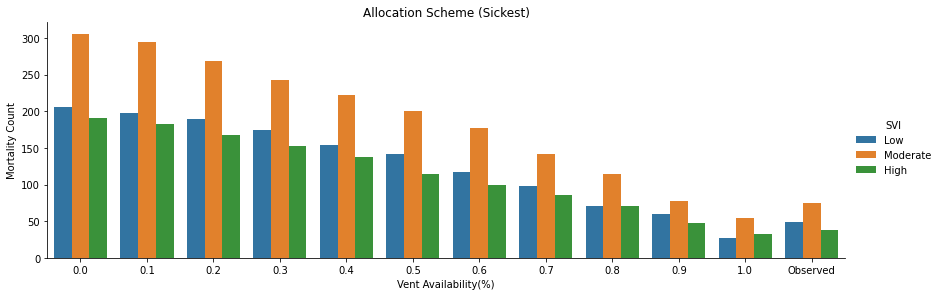

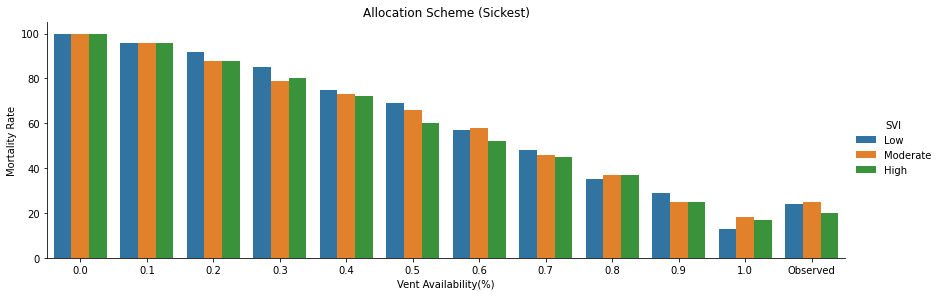

In [ ]:
visualize_count_mortality(df_base_sickest, 'Sickest')
visualize_percentage_mortality(df_base_sickest, 'Sickest')

# Allocate ventilators (Simulation)

## New York

In [ ]:
ls_df_count_death_level = [] # Store dataframes for all scarcity levels

for pct in vent_availability:
    print('-------------------------{}-------------------------'.format(round(pct,1)))
    ls_df_count_death_iter = []    # Store dataframes of death counts within iteration

    for _ in range(iter_simulation):    # Iterate 1000 times per scarcity level
        # Allocate ventilators to patients
        allocation = Allocation(df_sample, pct, calibration_mortality_sofa)
        df_death = allocation.new_york()
        ls_df_count_death_iter.append(df_death)
  
    df_count_death_level = pd.concat(ls_df_count_death_iter)
    df_count_death_level.rename(columns={'cat_SVI': 'SVI', 'sum': 'count_death'}, inplace=True)
    df_count_death_level = df_count_death_level.groupby('SVI').agg(['mean']).round(0).astype(int)
    df_count_death_level = df_count_death_level.reset_index(level=['SVI'], col_level=1)
    df_count_death_level.columns = df_count_death_level.columns.droplevel(0)
    df_count_death_level.rename(columns={'mean': 'count_death'}, inplace=True)

    df_count_death_level['level'] = round(pct, 1)
    df_count_death_level['type_allocation'] = 'New York'
    df_count_death_level['avg_death'] = statistics.mean(df_count_death_level.loc[: ,'count_death'])
    df_count_death_level['percentage_death'] = df_count_death_level.apply(lambda row: percentage_death(row), axis=1)
    ls_df_count_death_level.append(df_count_death_level)

df_new_york = pd.concat(ls_df_count_death_level)
df_base_new_york = pd.concat([death_base, df_new_york])
df_base_new_york[['count_death', 'avg_death', 'percentage_death']] = df_base_new_york[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------
-------------------------0.5-------------------------
-------------------------0.6-------------------------
-------------------------0.7-------------------------
-------------------------0.8-------------------------
-------------------------0.9-------------------------
-------------------------1.0-------------------------


In [ ]:
df_new_york_tb = df_base_new_york.loc[df_base_new_york['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_new_york_tb)

,SVI,count_death,level,type_allocation
0,Low,49,2.0,Baseline
1,Moderate,75,2.0,Baseline
2,High,38,2.0,Baseline
0,High,191,0.0,New York
1,Low,206,0.0,New York
2,Moderate,306,0.0,New York
0,High,172,0.1,New York
1,Low,186,0.1,New York
2,Moderate,275,0.1,New York
0,High,153,0.2,New York


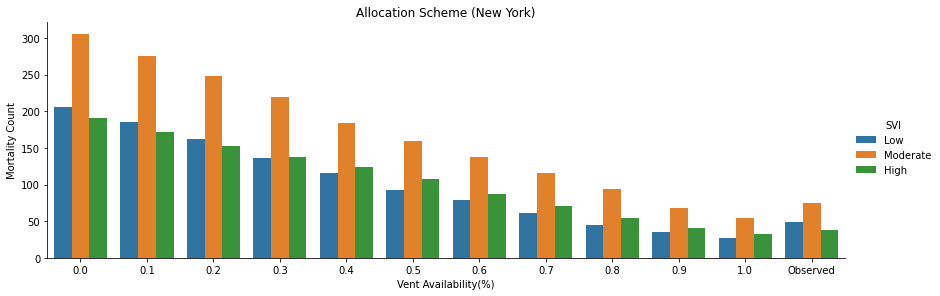

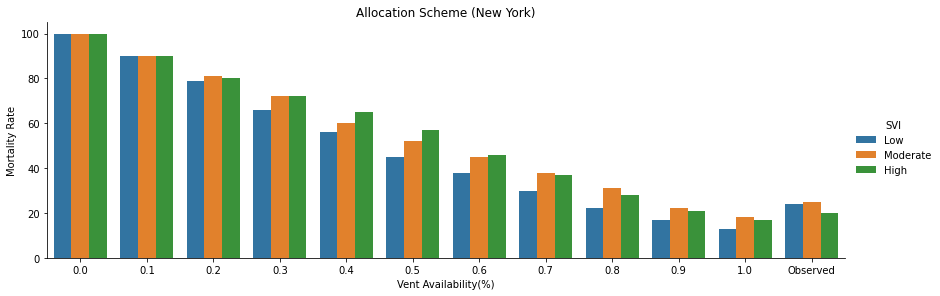

In [ ]:
visualize_count_mortality(df_base_new_york, 'New York')
visualize_percentage_mortality(df_base_new_york, 'New York')

## Lottery

In [ ]:
count_svi

Counter({'High': 191, 'Low': 206, 'Moderate': 306})

In [ ]:
ls_df_count_death_level = [] # Store dataframes for all scarcity levels

for pct in vent_availability:
    print('-------------------------{}-------------------------'.format(round(pct,1)))
    ls_df_count_death_iter = []    # Store dataframes of SVI death counts within iteration

    for _ in range(iter_simulation):    # Iterate 1000 times per scarcity level
        # Allocate ventilators to patients
        allocation = Allocation(df_sample, pct, calibration_mortality_sofa)
        df_death = allocation.lottery()
        ls_df_count_death_iter.append(df_death)

    df_count_death_level = pd.concat(ls_df_count_death_iter)
    df_count_death_level.rename(columns={'cat_SVI': 'SVI', 'sum': 'count_death'}, inplace=True)
    df_count_death_level = df_count_death_level.groupby('SVI').agg(['mean']).round(0).astype(int)
    df_count_death_level = df_count_death_level.reset_index(level=['SVI'], col_level=1)
    df_count_death_level.columns = df_count_death_level.columns.droplevel(0)
    df_count_death_level.rename(columns={'mean': 'count_death'}, inplace=True)

    df_count_death_level['level'] = round(pct, 1)
    df_count_death_level['type_allocation'] = 'Lottery'
    df_count_death_level['avg_death'] = statistics.mean(df_count_death_level.loc[: ,'count_death'])
    df_count_death_level['percentage_death'] = df_count_death_level.apply(lambda row: percentage_death(row), axis=1)
    ls_df_count_death_level.append(df_count_death_level)

df_lottery = pd.concat(ls_df_count_death_level)
df_base_lottery = pd.concat([death_base, df_lottery])
df_base_lottery[['count_death', 'avg_death', 'percentage_death']] = df_base_lottery[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------
-------------------------0.5-------------------------
-------------------------0.6-------------------------
-------------------------0.7-------------------------
-------------------------0.8-------------------------
-------------------------0.9-------------------------
-------------------------1.0-------------------------


In [ ]:
df_lottery_tb = df_base_lottery.loc[df_base_lottery['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_lottery_tb)

,SVI,count_death,level,type_allocation
0,Low,49,2.0,Baseline
1,Moderate,75,2.0,Baseline
2,High,38,2.0,Baseline
0,High,191,0.0,Lottery
1,Low,206,0.0,Lottery
2,Moderate,306,0.0,Lottery
0,High,175,0.1,Lottery
1,Low,188,0.1,Lottery
2,Moderate,281,0.1,Lottery
0,High,159,0.2,Lottery


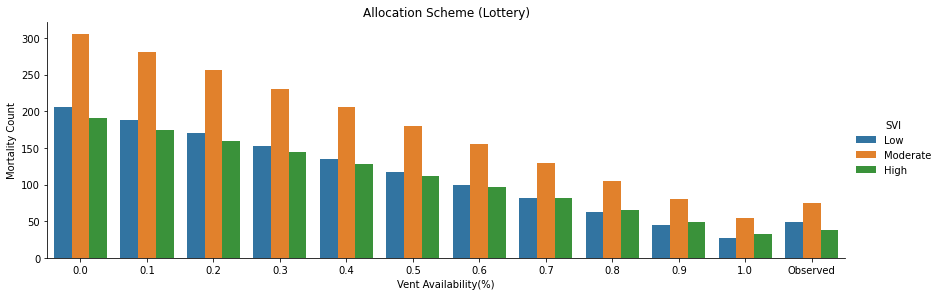

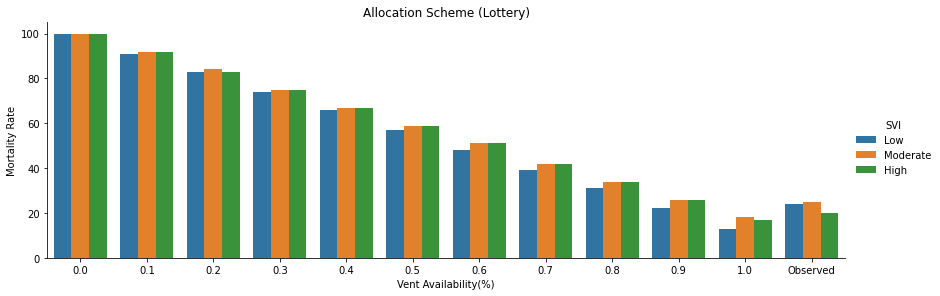

In [ ]:
visualize_count_mortality(df_base_lottery, 'Lottery')
visualize_percentage_mortality(df_base_lottery, 'Lottery')

# Total

In [ ]:
df_csc_all = pd.concat([ 
    df_maryland[['type_allocation', 'level', 'avg_death']], 
    df_max_lives_years[['type_allocation', 'level', 'avg_death']], 
    df_youngest[['type_allocation', 'level', 'avg_death']], 
    df_sickest[['type_allocation', 'level', 'avg_death']],
    df_new_york[['type_allocation', 'level', 'avg_death']],
    df_lottery[['type_allocation', 'level', 'avg_death']], 
])

df_csc_all

,type_allocation,level,avg_death
0,Maryland,0.0,234.333333
1,Maryland,0.0,234.333333
2,Maryland,0.0,234.333333
0,Maryland,0.1,211.143333
2,Maryland,0.1,211.143333
...,...,...,...
1,Lottery,0.9,58.000000
2,Lottery,0.9,58.000000
0,Lottery,1.0,38.000000
1,Lottery,1.0,38.000000


In [ ]:
def visualize_percentage_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='percentage_death', hue='SVI', data=df, kind='bar', order=x_val, height=4, aspect=3)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Rate')
    sns_plot._legend.set_title('SVI')
    sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/percentage_death_{}_svi.png".format(policy))

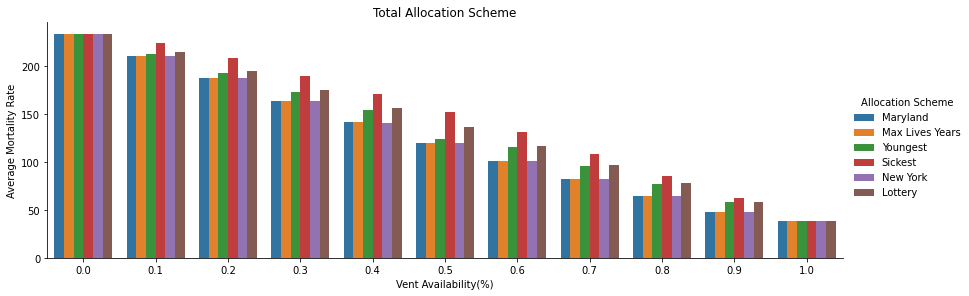

In [ ]:
#%matplotlib qt
sns_plot = sns.catplot(x='level', y='avg_death', hue='type_allocation', data=df_csc_all[df_csc_all['level']!=2.0], kind='bar', legend_out=True, height=4, aspect=3)
plt.title('Total Allocation Scheme')
sns_plot._legend.set_title('Allocation Scheme')
plt.xlabel('Vent Availability(%)')
plt.ylabel('Average Mortality Rate')
sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/percentage_death_total_avg_svi.png")

# Statistics

## Table: SVI group mortality

In [ ]:
df_tb_comb = pd.concat([df_maryland_tb, df_max_lives_years_tb, df_youngest_tb, df_sickest_tb, df_new_york_tb, df_lottery_tb])
df_tb_comb.reset_index(drop=True, inplace=True)
df_tb_comb.rename(columns={'type_allocation': 'allocation', 'level': 'vent availability(%)'}, inplace=True)

for i, value in df_tb_comb.iterrows():
    if df_tb_comb.loc[i, 'SVI']=='Low':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['Low']
    elif df_tb_comb.loc[i, 'SVI']=='Moderate':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['Moderate']
    elif df_tb_comb.loc[i, 'SVI']=='High':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['High']
        
    df_tb_comb.loc[i, 'mortality'] = round(df_tb_comb.loc[i, 'count_death']/df_tb_comb.loc[i, 'count_patients']*100, 1)

df_tb_comb

,SVI,count_death,vent availability(%),allocation,count_patients,mortality
0,High,191,0.0,Maryland,191.0,100.0
1,Low,206,0.0,Maryland,206.0,100.0
2,Moderate,306,0.0,Maryland,306.0,100.0
3,High,165,0.1,Maryland,191.0,86.4
4,Low,186,0.1,Maryland,206.0,90.3
...,...,...,...,...,...,...
205,Low,45,0.9,Lottery,206.0,21.8
206,Moderate,80,0.9,Lottery,306.0,26.1
207,High,33,1.0,Lottery,191.0,17.3
208,Low,27,1.0,Lottery,206.0,13.1


In [ ]:
cols_order_allocation = ['Maryland', 'Max Lives Years', 'Youngest', 'Sickest', 'New York', 'Lottery']
cols_order_svi = ['Low', 'Moderate', 'High']
df_tb_comb['allocation'] = df_tb_comb['allocation'].astype(pd.api.types.CategoricalDtype(categories=cols_order_allocation))
df_tb_comb['SVI'] = df_tb_comb['SVI'].astype(pd.api.types.CategoricalDtype(categories=cols_order_svi))
df_tb_pivot = df_tb_comb.pivot_table(values='mortality', columns='vent availability(%)', index=['allocation', 'SVI'])

#dfi.export(df_tb_pivot, 'figure/svi/tb_mortality_svi.png')
#dfi.export(df_tb_pivot, '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/tb_mortality_svi.png')
df_tb_pivot

vent availability(%)        0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7  \
allocation      SVI                                                         
Maryland        Low       100.0  90.3  79.1  65.5  56.8  44.7  39.3  30.1   
                Moderate  100.0  92.2  81.0  71.9  60.5  52.6  44.8  37.6   
                High      100.0  86.4  79.6  72.3  64.9  56.0  45.0  37.2   
Max Lives Years Low       100.0  88.3  79.1  66.5  56.8  44.2  39.3  30.1   
                Moderate  100.0  91.8  81.0  71.9  60.5  52.3  45.1  37.6   
                High      100.0  89.0  79.6  71.2  64.9  57.1  44.5  37.2   
Youngest        Low       100.0  90.3  85.4  75.7  69.4  60.2  53.9  48.1   
                Moderate  100.0  92.5  83.3  76.5  66.3  53.3  51.0  40.5   
                High      100.0  89.0  77.0  67.5  60.7  45.0  42.4  34.6   
Sickest         Low       100.0  95.6  91.7  85.0  74.8  68.9  56.8  47.6   
                Moderate  100.0  96.4  87.9  79.4  72.5  65.7  57.8  46.1   
                High      100.0  95.8  88.0  80.1  72.3  60.2  51.8  45.0   
New York        Low       100.0  90.3  78.6  66.0  56.3  44.7  38.3  29.6   
                Moderate  100.0  89.9  81.0  71.6  60.1  52.3  45.1  37.9   
                High      100.0  90.1  80.1  72.3  64.9  56.5  45.5  37.2   
Lottery         Low       100.0  91.3  82.5  73.8  65.5  56.8  48.1  39.3   
                Moderate  100.0  91.8  83.7  75.5  67.3  58.8  51.0  42.5   
                High      100.0  91.6  83.2  75.4  67.0  58.6  50.8  42.4   

vent availability(%)       0.8   0.9   1.0  
allocation      SVI                         
Maryland        Low       22.3  17.0  13.1  
                Moderate  30.7  21.9  17.6  
                High      27.7  21.5  17.3  
Max Lives Years Low       22.3  17.0  13.1  
                Moderate  30.7  22.5  17.6  
                High      27.2  20.9  17.3  
Youngest        Low       35.4  25.2  13.1  
                Moderate  33.7  25.8  17.6  
                High      29.3  23.6  17.3  
Sickest         Low       34.5  29.1  13.1  
                Moderate  37.3  25.5  17.6  
                High      37.2  25.1  17.3  
New York        Low       21.8  17.0  13.1  
                Moderate  30.7  22.2  17.6  
                High      28.3  20.9  17.3  
Lottery         Low       30.6  21.8  13.1  
                Moderate  34.3  26.1  17.6  
                High      34.0  25.7  17.3

## Table: Max-Min Difference

In [ ]:
cols_max_min = ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tmp = df_tb_pivot.reset_index(level=['allocation', 'SVI'], col_level=1)
df_tmp

vent availability(%),allocation,SVI,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,Maryland,Low,100.0,90.3,79.1,65.5,56.8,44.7,39.3,30.1,22.3,17.0,13.1
1,Maryland,Moderate,100.0,92.2,81.0,71.9,60.5,52.6,44.8,37.6,30.7,21.9,17.6
2,Maryland,High,100.0,86.4,79.6,72.3,64.9,56.0,45.0,37.2,27.7,21.5,17.3
3,Max Lives Years,Low,100.0,88.3,79.1,66.5,56.8,44.2,39.3,30.1,22.3,17.0,13.1
4,Max Lives Years,Moderate,100.0,91.8,81.0,71.9,60.5,52.3,45.1,37.6,30.7,22.5,17.6
5,Max Lives Years,High,100.0,89.0,79.6,71.2,64.9,57.1,44.5,37.2,27.2,20.9,17.3
6,Youngest,Low,100.0,90.3,85.4,75.7,69.4,60.2,53.9,48.1,35.4,25.2,13.1
7,Youngest,Moderate,100.0,92.5,83.3,76.5,66.3,53.3,51.0,40.5,33.7,25.8,17.6
8,Youngest,High,100.0,89.0,77.0,67.5,60.7,45.0,42.4,34.6,29.3,23.6,17.3
9,Sickest,Low,100.0,95.6,91.7,85.0,74.8,68.9,56.8,47.6,34.5,29.1,13.1


In [ ]:
df_tmp.groupby('allocation').agg(['max', 'min'])

0.0          0.1         0.2         0.3         0.4        \
                   max    min   max   min   max   min   max   min   max   min   
allocation                                                                      
Maryland         100.0  100.0  92.2  86.4  81.0  79.1  72.3  65.5  64.9  56.8   
Max Lives Years  100.0  100.0  91.8  88.3  81.0  79.1  71.9  66.5  64.9  56.8   
Youngest         100.0  100.0  92.5  89.0  85.4  77.0  76.5  67.5  69.4  60.7   
Sickest          100.0  100.0  96.4  95.6  91.7  87.9  85.0  79.4  74.8  72.3   
New York         100.0  100.0  90.3  89.9  81.0  78.6  72.3  66.0  64.9  56.3   
Lottery          100.0  100.0  91.8  91.3  83.7  82.5  75.5  73.8  67.3  65.5   

                  0.5         0.6         0.7         0.8         0.9        \
                  max   min   max   min   max   min   max   min   max   min   
allocation                                                                    
Maryland         56.0  44.7  45.0  39.3  37.6  30.1  30.7  22.3  21.9  17.0   
Max Lives Years  57.1  44.2  45.1  39.3  37.6  30.1  30.7  22.3  22.5  17.0   
Youngest         60.2  45.0  53.9  42.4  48.1  34.6  35.4  29.3  25.8  23.6   
Sickest          68.9  60.2  57.8  51.8  47.6  45.0  37.3  34.5  29.1  25.1   
New York         56.5  44.7  45.5  38.3  37.9  29.6  30.7  21.8  22.2  17.0   
Lottery          58.8  56.8  51.0  48.1  42.5  39.3  34.3  30.6  26.1  21.8   

                  1.0        
                  max   min  
allocation                   
Maryland         17.6  13.1  
Max Lives Years  17.6  13.1  
Youngest         17.6  13.1  
Sickest          17.6  13.1  
New York         17.6  13.1  
Lottery          17.6  13.1

In [ ]:
cols_order_allocation = ['Maryland', 'Max Lives Years', 'Youngest', 'Sickest', 'New York', 'Lottery']
df_diff_max_min = df_tmp.groupby('allocation').agg(np.ptp)
df_diff_max_min = df_diff_max_min.reindex(cols_order_allocation)
df_diff_max_min

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,5.8,1.9,6.8,8.1,11.3,5.7,7.5,8.4,4.9,4.5
Max Lives Years,0.0,3.5,1.9,5.4,8.1,12.9,5.8,7.5,8.4,5.5,4.5
Youngest,0.0,3.5,8.4,9.0,8.7,15.2,11.5,13.5,6.1,2.2,4.5
Sickest,0.0,0.8,3.8,5.6,2.5,8.7,6.0,2.6,2.8,4.0,4.5
New York,0.0,0.4,2.4,6.3,8.6,11.8,7.2,8.3,8.9,5.2,4.5
Lottery,0.0,0.5,1.2,1.7,1.8,2.0,2.9,3.2,3.7,4.3,4.5


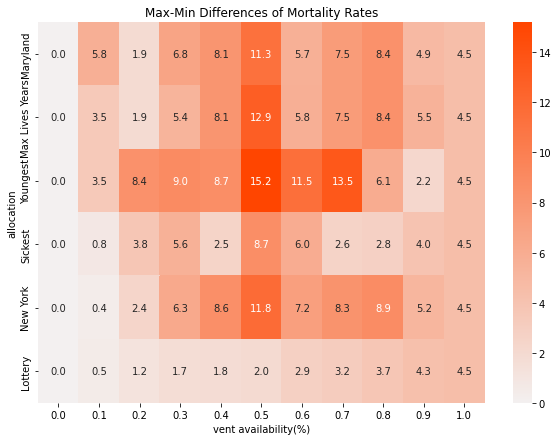

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_max_min, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Max-Min Differences of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_max_min_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_max_min_svi.png")

In [ ]:
display(df_diff_max_min.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_max_min.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_max_min_allo_svi.png')

display(df_diff_max_min.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_max_min.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_max_min_avai_svi.png')

,AVG
allocation,
Maryland,5.9
Max Lives Years,5.8
Youngest,7.5
Sickest,3.8
New York,5.8
Lottery,2.3


,AVG
vent availability(%),
0.0,0.0
0.1,2.4
0.2,3.3
0.3,5.8
0.4,6.3
0.5,10.3
0.6,6.5
0.7,7.1
0.8,6.4


In [ ]:
ls_avai_1_9 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
display(df_diff_max_min[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_max_min[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_max_min_allo_0.1_0.9_svi.png')

display(df_diff_max_min[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_max_min[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_max_min_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,6.7
Max Lives Years,6.6
Youngest,8.7
Sickest,4.1
New York,6.6
Lottery,2.4


,AVG
vent availability(%),
0.1,2.4
0.2,3.3
0.3,5.8
0.4,6.3
0.5,10.3
0.6,6.5
0.7,7.1
0.8,6.4
0.9,4.4


## Table: High&Moderate-Low Difference (Reference Point: Best Group)

In [ ]:
cols_rest_low = ['allocation', 'SVI', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tmp = df_tb_pivot.reset_index(level=['allocation', 'SVI'], col_level=1)
df_tmp

vent availability(%),allocation,SVI,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,Maryland,Low,100.0,90.3,79.1,65.5,56.8,44.7,39.3,30.1,22.3,17.0,13.1
1,Maryland,Moderate,100.0,92.2,81.0,71.9,60.5,52.6,44.8,37.6,30.7,21.9,17.6
2,Maryland,High,100.0,86.4,79.6,72.3,64.9,56.0,45.0,37.2,27.7,21.5,17.3
3,Max Lives Years,Low,100.0,88.3,79.1,66.5,56.8,44.2,39.3,30.1,22.3,17.0,13.1
4,Max Lives Years,Moderate,100.0,91.8,81.0,71.9,60.5,52.3,45.1,37.6,30.7,22.5,17.6
5,Max Lives Years,High,100.0,89.0,79.6,71.2,64.9,57.1,44.5,37.2,27.2,20.9,17.3
6,Youngest,Low,100.0,90.3,85.4,75.7,69.4,60.2,53.9,48.1,35.4,25.2,13.1
7,Youngest,Moderate,100.0,92.5,83.3,76.5,66.3,53.3,51.0,40.5,33.7,25.8,17.6
8,Youngest,High,100.0,89.0,77.0,67.5,60.7,45.0,42.4,34.6,29.3,23.6,17.3
9,Sickest,Low,100.0,95.6,91.7,85.0,74.8,68.9,56.8,47.6,34.5,29.1,13.1


In [ ]:
df_h = df_tmp.loc[df_tmp['SVI']=='High', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_h

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,100.0,86.4,79.6,72.3,64.9,56.0,45.0,37.2,27.7,21.5,17.3
Max Lives Years,100.0,89.0,79.6,71.2,64.9,57.1,44.5,37.2,27.2,20.9,17.3
Youngest,100.0,89.0,77.0,67.5,60.7,45.0,42.4,34.6,29.3,23.6,17.3
Sickest,100.0,95.8,88.0,80.1,72.3,60.2,51.8,45.0,37.2,25.1,17.3
New York,100.0,90.1,80.1,72.3,64.9,56.5,45.5,37.2,28.3,20.9,17.3
Lottery,100.0,91.6,83.2,75.4,67.0,58.6,50.8,42.4,34.0,25.7,17.3


In [ ]:
df_m = df_tmp.loc[df_tmp['SVI']=='Moderate', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_m

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,100.0,92.2,81.0,71.9,60.5,52.6,44.8,37.6,30.7,21.9,17.6
Max Lives Years,100.0,91.8,81.0,71.9,60.5,52.3,45.1,37.6,30.7,22.5,17.6
Youngest,100.0,92.5,83.3,76.5,66.3,53.3,51.0,40.5,33.7,25.8,17.6
Sickest,100.0,96.4,87.9,79.4,72.5,65.7,57.8,46.1,37.3,25.5,17.6
New York,100.0,89.9,81.0,71.6,60.1,52.3,45.1,37.9,30.7,22.2,17.6
Lottery,100.0,91.8,83.7,75.5,67.3,58.8,51.0,42.5,34.3,26.1,17.6


In [ ]:
df_l = df_tmp.loc[df_tmp['SVI']=='Low', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_l

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,100.0,90.3,79.1,65.5,56.8,44.7,39.3,30.1,22.3,17.0,13.1
Max Lives Years,100.0,88.3,79.1,66.5,56.8,44.2,39.3,30.1,22.3,17.0,13.1
Youngest,100.0,90.3,85.4,75.7,69.4,60.2,53.9,48.1,35.4,25.2,13.1
Sickest,100.0,95.6,91.7,85.0,74.8,68.9,56.8,47.6,34.5,29.1,13.1
New York,100.0,90.3,78.6,66.0,56.3,44.7,38.3,29.6,21.8,17.0,13.1
Lottery,100.0,91.3,82.5,73.8,65.5,56.8,48.1,39.3,30.6,21.8,13.1


### Moderate-Low (Absolute Difference)

In [ ]:
df_diff_m_l_ab = df_m.subtract(df_l)
df_diff_m_l_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,1.9,1.9,6.4,3.7,7.9,5.5,7.5,8.4,4.9,4.5
Max Lives Years,0.0,3.5,1.9,5.4,3.7,8.1,5.8,7.5,8.4,5.5,4.5
Youngest,0.0,2.2,-2.1,0.8,-3.1,-6.9,-2.9,-7.6,-1.7,0.6,4.5
Sickest,0.0,0.8,-3.8,-5.6,-2.3,-3.2,1.0,-1.5,2.8,-3.6,4.5
New York,0.0,-0.4,2.4,5.6,3.8,7.6,6.8,8.3,8.9,5.2,4.5
Lottery,0.0,0.5,1.2,1.7,1.8,2.0,2.9,3.2,3.7,4.3,4.5


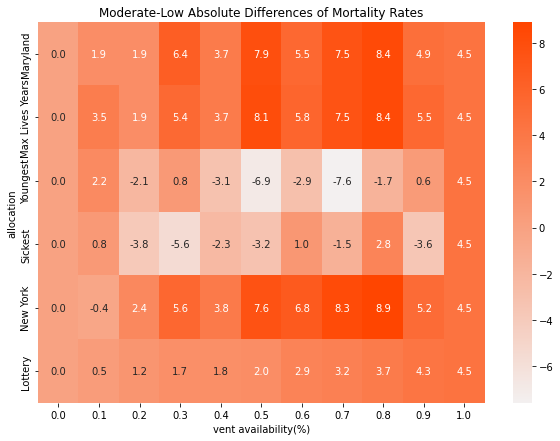

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_l_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Moderate-Low Absolute Differences of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_m_l_ab_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_m_l_ab_svi.png")

In [ ]:
display(df_diff_m_l_ab.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_ab_allo_svi.png')

display(df_diff_m_l_ab.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_ab_avai_svi.png')

,AVG
allocation,
Maryland,4.8
Max Lives Years,4.9
Youngest,-1.5
Sickest,-1.0
New York,4.8
Lottery,2.3


,AVG
vent availability(%),
0.0,0.0
0.1,1.4
0.2,0.3
0.3,2.4
0.4,1.3
0.5,2.6
0.6,3.2
0.7,2.9
0.8,5.1


In [ ]:
display(df_diff_m_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_ab_allo_0.1_0.9_svi.png')

display(df_diff_m_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_ab_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,5.3
Max Lives Years,5.5
Youngest,-2.3
Sickest,-1.7
New York,5.4
Lottery,2.4


,AVG
vent availability(%),
0.1,1.4
0.2,0.3
0.3,2.4
0.4,1.3
0.5,2.6
0.6,3.2
0.7,2.9
0.8,5.1
0.9,2.8


### Moderate-Low (Relative Difference)

In [ ]:
df_diff_m_l_re = df_m.subtract(df_l)
df_diff_m_l_re = df_diff_m_l_re.divide(df_l)*100
df_diff_m_l_re = df_diff_m_l_re.round(1)
df_diff_m_l_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,2.1,2.4,9.8,6.5,17.7,14.0,24.9,37.7,28.8,34.4
Max Lives Years,0.0,4.0,2.4,8.1,6.5,18.3,14.8,24.9,37.7,32.4,34.4
Youngest,0.0,2.4,-2.5,1.1,-4.5,-11.5,-5.4,-15.8,-4.8,2.4,34.4
Sickest,0.0,0.8,-4.1,-6.6,-3.1,-4.6,1.8,-3.2,8.1,-12.4,34.4
New York,0.0,-0.4,3.1,8.5,6.7,17.0,17.8,28.0,40.8,30.6,34.4
Lottery,0.0,0.5,1.5,2.3,2.7,3.5,6.0,8.1,12.1,19.7,34.4


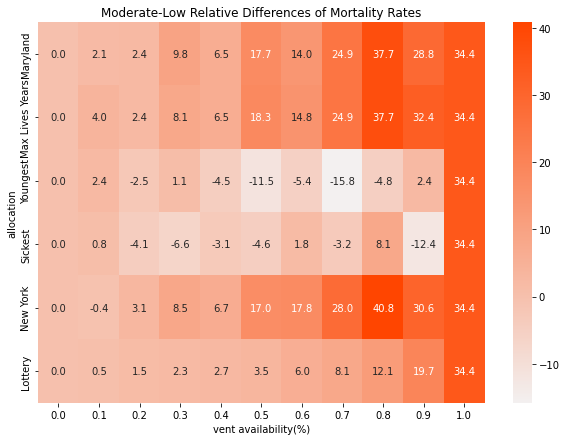

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_l_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Moderate-Low Relative Differences of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_m_l_re_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_m_l_re_svi.png")

In [ ]:
display(df_diff_m_l_re.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_re_allo_svi.png')

display(df_diff_m_l_re.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_re_avai_svi.png')

,AVG
allocation,
Maryland,16.2
Max Lives Years,16.7
Youngest,-0.4
Sickest,1.0
New York,17.0
Lottery,8.3


,AVG
vent availability(%),
0.0,0.0
0.1,1.6
0.2,0.5
0.3,3.9
0.4,2.5
0.5,6.7
0.6,8.2
0.7,11.1
0.8,21.9


In [ ]:
display(df_diff_m_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_re_allo_0.1_0.9_svi.png')

display(df_diff_m_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_m_l_re_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,16.0
Max Lives Years,16.6
Youngest,-4.3
Sickest,-2.6
New York,16.9
Lottery,6.3


,AVG
vent availability(%),
0.1,1.6
0.2,0.5
0.3,3.9
0.4,2.5
0.5,6.7
0.6,8.2
0.7,11.1
0.8,21.9
0.9,16.9


### High-Low (Absolute Difference)

In [ ]:
df_diff_h_l_ab = df_h.subtract(df_l)
df_diff_h_l_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,-3.9,0.5,6.8,8.1,11.3,5.7,7.1,5.4,4.5,4.2
Max Lives Years,0.0,0.7,0.5,4.7,8.1,12.9,5.2,7.1,4.9,3.9,4.2
Youngest,0.0,-1.3,-8.4,-8.2,-8.7,-15.2,-11.5,-13.5,-6.1,-1.6,4.2
Sickest,0.0,0.2,-3.7,-4.9,-2.5,-8.7,-5.0,-2.6,2.7,-4.0,4.2
New York,0.0,-0.2,1.5,6.3,8.6,11.8,7.2,7.6,6.5,3.9,4.2
Lottery,0.0,0.3,0.7,1.6,1.5,1.8,2.7,3.1,3.4,3.9,4.2


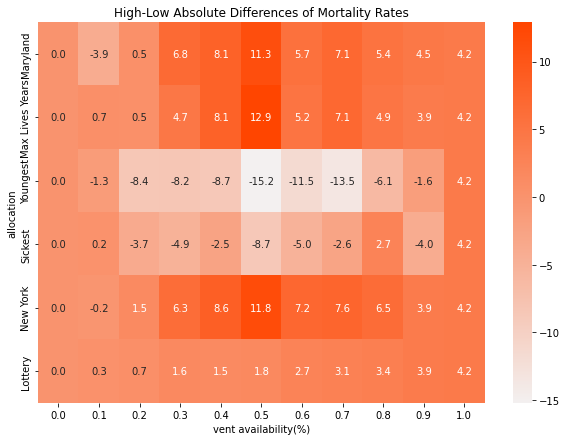

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_h_l_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('High-Low Absolute Differences of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_h_l_ab_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_h_l_ab_svi.png")

In [ ]:
display(df_diff_h_l_ab.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_ab_allo_svi.png')

display(df_diff_h_l_ab.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_ab_avai_svi.png')

,AVG
allocation,
Maryland,4.5
Max Lives Years,4.7
Youngest,-6.4
Sickest,-2.2
New York,5.2
Lottery,2.1


,AVG
vent availability(%),
0.0,0.0
0.1,-0.7
0.2,-1.5
0.3,1.0
0.4,2.5
0.5,2.3
0.6,0.7
0.7,1.5
0.8,2.8


In [ ]:
display(df_diff_h_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#fi.export(df_diff_h_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_ab_allo_0.1_0.9_svi.png')

display(df_diff_h_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_ab_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,5.1
Max Lives Years,5.3
Youngest,-8.3
Sickest,-3.2
New York,5.9
Lottery,2.1


,AVG
vent availability(%),
0.1,-0.7
0.2,-1.5
0.3,1.0
0.4,2.5
0.5,2.3
0.6,0.7
0.7,1.5
0.8,2.8
0.9,1.8


### High-Low (Relative Difference)

In [ ]:
df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)
df_diff_h_l_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,-4.3,0.6,10.4,14.3,25.3,14.5,23.6,24.2,26.5,32.1
Max Lives Years,0.0,0.8,0.6,7.1,14.3,29.2,13.2,23.6,22.0,22.9,32.1
Youngest,0.0,-1.4,-9.8,-10.8,-12.5,-25.2,-21.3,-28.1,-17.2,-6.3,32.1
Sickest,0.0,0.2,-4.0,-5.8,-3.3,-12.6,-8.8,-5.5,7.8,-13.7,32.1
New York,0.0,-0.2,1.9,9.5,15.3,26.4,18.8,25.7,29.8,22.9,32.1
Lottery,0.0,0.3,0.8,2.2,2.3,3.2,5.6,7.9,11.1,17.9,32.1


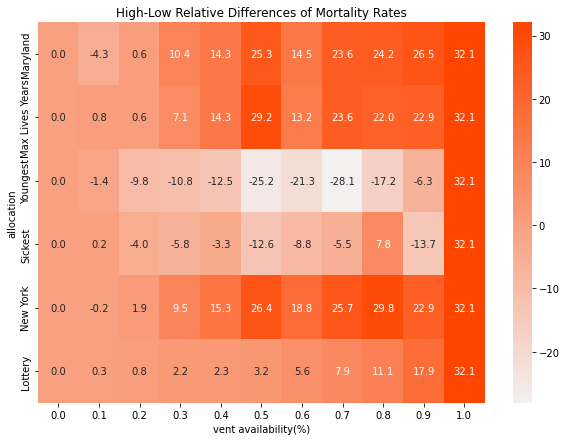

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_h_l_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('High-Low Relative Differences of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_h_l_re_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_h_l_re_svi.png")

In [ ]:
display(df_diff_h_l_re.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_re_allo_svi.png')

display(df_diff_h_l_re.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_re_avai_svi.png')

,AVG
allocation,
Maryland,15.2
Max Lives Years,15.1
Youngest,-9.1
Sickest,-1.2
New York,16.6
Lottery,7.6


,AVG
vent availability(%),
0.0,0.0
0.1,-0.8
0.2,-1.6
0.3,2.1
0.4,5.1
0.5,7.7
0.6,3.7
0.7,7.9
0.8,13.0


In [ ]:
display(df_diff_h_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_re_allo_0.1_0.9_svi.png')

display(df_diff_h_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_h_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_h_l_re_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,15.0
Max Lives Years,14.9
Youngest,-14.7
Sickest,-5.1
New York,16.7
Lottery,5.7


,AVG
vent availability(%),
0.1,-0.8
0.2,-1.6
0.3,2.1
0.4,5.1
0.5,7.7
0.6,3.7
0.7,7.9
0.8,13.0
0.9,11.7


### Avg(Moderate-White & High-White) (Absolute)

In [ ]:
df_diff_m_l = df_m.subtract(df_l)
df_diff_h_l = df_h.subtract(df_l)
df_diff_m_h_l_avg_ab = df_diff_m_l.add(df_diff_h_l).divide(2)
df_diff_m_h_l_avg_ab = df_diff_m_h_l_avg_ab.round(1)
df_diff_m_h_l_avg_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,-1.0,1.2,6.6,5.9,9.6,5.6,7.3,6.9,4.7,4.4
Max Lives Years,0.0,2.1,1.2,5.1,5.9,10.5,5.5,7.3,6.6,4.7,4.4
Youngest,0.0,0.5,-5.3,-3.7,-5.9,-11.1,-7.2,-10.6,-3.9,-0.5,4.4
Sickest,0.0,0.5,-3.8,-5.2,-2.4,-6.0,-2.0,-2.1,2.8,-3.8,4.4
New York,0.0,-0.3,2.0,5.9,6.2,9.7,7.0,8.0,7.7,4.5,4.4
Lottery,0.0,0.4,1.0,1.7,1.6,1.9,2.8,3.2,3.5,4.1,4.4


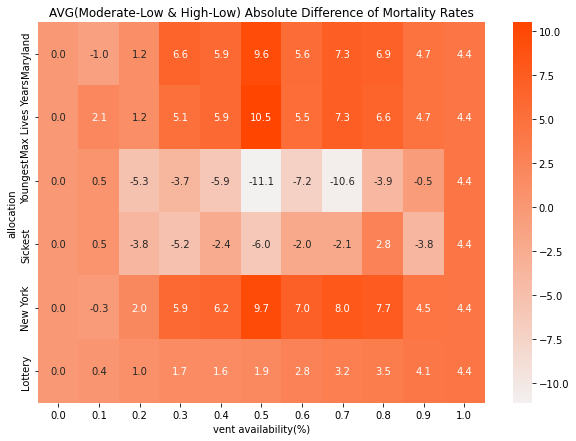

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_h_l_avg_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('AVG(Moderate-Low & High-Low) Absolute Difference of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_avg_ab_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_avg_ab_svi.png")

In [ ]:
display(df_diff_m_h_l_avg_ab.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_ab_allo_svi.png')

display(df_diff_m_h_l_avg_ab.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_ab_avai_svi.png')

,AVG
allocation,
Maryland,4.7
Max Lives Years,4.8
Youngest,-3.9
Sickest,-1.6
New York,5.0
Lottery,2.2


,AVG
vent availability(%),
0.0,0.0
0.1,0.4
0.2,-0.6
0.3,1.7
0.4,1.9
0.5,2.4
0.6,2.0
0.7,2.2
0.8,3.9


In [ ]:
display(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_ab_allo_0.1_0.9_svi.png')

display(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_ab_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,5.2
Max Lives Years,5.4
Youngest,-5.3
Sickest,-2.4
New York,5.6
Lottery,2.2


,AVG
vent availability(%),
0.1,0.4
0.2,-0.6
0.3,1.7
0.4,1.9
0.5,2.4
0.6,2.0
0.7,2.2
0.8,3.9
0.9,2.3


### Avg(Moderate-Low & High-Low) (Relative)

In [ ]:
df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)
df_diff_h_l_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,-4.3,0.6,10.4,14.3,25.3,14.5,23.6,24.2,26.5,32.1
Max Lives Years,0.0,0.8,0.6,7.1,14.3,29.2,13.2,23.6,22.0,22.9,32.1
Youngest,0.0,-1.4,-9.8,-10.8,-12.5,-25.2,-21.3,-28.1,-17.2,-6.3,32.1
Sickest,0.0,0.2,-4.0,-5.8,-3.3,-12.6,-8.8,-5.5,7.8,-13.7,32.1
New York,0.0,-0.2,1.9,9.5,15.3,26.4,18.8,25.7,29.8,22.9,32.1
Lottery,0.0,0.3,0.8,2.2,2.3,3.2,5.6,7.9,11.1,17.9,32.1


In [ ]:
df_diff_m_l_re = df_m.subtract(df_l)
df_diff_m_l_re = df_diff_m_l_re.divide(df_l)*100
df_diff_m_l_re = df_diff_m_l_re.round(1)

df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)

df_diff_m_h_l_avg_re = df_diff_m_l_re.add(df_diff_h_l_re).divide(2)
df_diff_m_h_l_avg_re = df_diff_m_h_l_avg_re.round(1)
df_diff_m_h_l_avg_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,-1.1,1.5,10.1,10.4,21.5,14.2,24.2,31.0,27.6,33.2
Max Lives Years,0.0,2.4,1.5,7.6,10.4,23.8,14.0,24.2,29.8,27.6,33.2
Youngest,0.0,0.5,-6.2,-4.9,-8.5,-18.4,-13.4,-22.0,-11.0,-2.0,33.2
Sickest,0.0,0.5,-4.0,-6.2,-3.2,-8.6,-3.5,-4.4,8.0,-13.0,33.2
New York,0.0,-0.3,2.5,9.0,11.0,21.7,18.3,26.8,35.3,26.8,33.2
Lottery,0.0,0.4,1.2,2.2,2.5,3.4,5.8,8.0,11.6,18.8,33.2


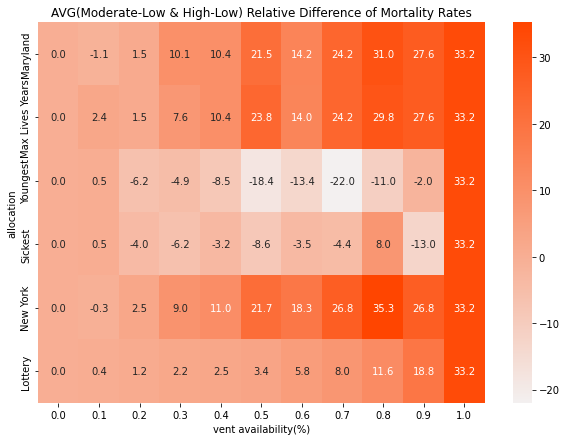

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_h_l_avg_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('AVG(Moderate-Low & High-Low) Relative Difference of Mortality Rates')
#plt.savefig("figure/svi/heat_mortality_diff_avg_re_svi.png")
plt.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figure/svi/heat_mortality_diff_avg_re_svi.png")

In [ ]:
display(df_diff_m_h_l_avg_re.mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_re_allo_svi.png')

display(df_diff_m_h_l_avg_re.mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_re_avai_svi.png')

,AVG
allocation,
Maryland,15.7
Max Lives Years,15.9
Youngest,-4.8
Sickest,-0.1
New York,16.8
Lottery,7.9


,AVG
vent availability(%),
0.0,0.0
0.1,0.4
0.2,-0.6
0.3,3.0
0.4,3.8
0.5,7.2
0.6,5.9
0.7,9.5
0.8,17.4


In [ ]:
display(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_re_allo_0.1_0.9_svi.png')

display(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
#dfi.export(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figure/svi/tb_avg_mortality_diff_avg_re_avai_0.1_0.9_svi.png')

,AVG
allocation,
Maryland,15.5
Max Lives Years,15.7
Youngest,-9.5
Sickest,-3.8
New York,16.8
Lottery,6.0


,AVG
vent availability(%),
0.1,0.4
0.2,-0.6
0.3,3.0
0.4,3.8
0.5,7.2
0.6,5.9
0.7,9.5
0.8,17.4
0.9,14.3
